# **RECOMMENDATION SYSTEM PROJECT**

### **Dataset Overview**
1. **events.csv**
    - Columns: timestamp, visitorid, event (view, addtocart, transaction), itemid, transactionid
    - Purpose: Core interaction log between users and items (implicit feedback data)

2. **item_properties_part1.csv & item_properties_part2.csv**
    - Columns: timestamp, itemid, property, value
    - Notes:
        - The property includes things like categoryid, available, and numeric/hashed attributes.
        - Multiple rows per itemid (one per property change or update).
        - timestamp means I may need temporal alignment—match properties to events based on closest date before the event.

3. **category_tree.csv**
    - Columns: categoryid, parentid
    - Purpose: Defines category hierarchy; needed for higher-level grouping and cold-start handling.

### **Analytical Questions**
1. Which items should be recommended to each user given their last n interactions
2. Which item properties best predict add to cart events
3. How does time of day and day of week influence the probability of add to cart
4. What is the effect of category affinity on recommendation precision
5. Which users exhibit abnormal behaviour that should be filtered before modelling
6. How does a hybrid of collaborative and content representations compare with pure methods
7. How robust is performance to cold start for new items and new users
8. How do price or availability changes affect conversion propensity

### **Step 1: Importing the necessary libraries**

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
custom_colors = ['#AF3E3E', '#CD5656', '#E55050', '#DA6C6C', '#F49BAB', '#FFE1E0']
sns.set_palette(sns.color_palette(custom_colors))

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve,auc, precision_recall_curve

# Resampling Techniques for Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Utility
import warnings
warnings.filterwarnings('ignore')

## **Step 2: Data Preparation**

### ***A. Loading the item_property datasets***


In [2]:
# Load both property files
use_cols = ["timestamp", "itemid", "property", "value"]

chunks1 = pd.read_csv("item_properties_part1.csv", usecols=use_cols, chunksize=1_000_000) #loading in chunks because of the size of the dataset
chunks2 = pd.read_csv("item_properties_part2.csv", usecols=use_cols, chunksize=1_000_000)

item_props = pd.concat([chunk for chunk in chunks1] + [chunk for chunk in chunks2], ignore_index=True)

In [3]:
item_props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


### ***B. Extract category Mapping***
- Cleaning the category information so it’s usable

In [4]:
# Filter rows where property is exactly 'categoryid'
category_mapping = item_props[item_props['property'] == 'categoryid'][['itemid', 'value']]

# Rename value -> categoryid
category_mapping = category_mapping.rename(columns={'value': 'categoryid'})

# Ensure categoryid is integer
category_mapping['categoryid'] = category_mapping['categoryid'].astype(int)

category_mapping.head()

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


- Linking events to category IDs (static version).

In [5]:
# First load the events dataset
events = pd.read_csv("events.csv")

# Merging it using the itemid
events = events.merge(category_mapping, on="itemid",how="left")

### ***C. Checks after the merge***

In [6]:
# 1a peek at columns and a few rows
events.head(10)


,timestamp,visitorid,event,itemid,transactionid,categoryid
0,1433221332117,257597,view,355908,NaN,1173.0
1,1433224214164,992329,view,248676,NaN,1231.0
2,1433221999827,111016,view,318965,NaN,NaN
3,1433221955914,483717,view,253185,NaN,914.0
4,1433221337106,951259,view,367447,NaN,1613.0
5,1433221337106,951259,view,367447,NaN,1613.0
6,1433221337106,951259,view,367447,NaN,1613.0
7,1433221337106,951259,view,367447,NaN,1613.0
8,1433221337106,951259,view,367447,NaN,1613.0
9,1433221337106,951259,view,367447,NaN,1613.0


In [7]:
# 1b confirm new column exists and types are sensible
events.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
categoryid       float64
dtype: object

In [8]:
# 1c basic null audit on the new column
events['categoryid'].isna().mean()  # share of events without a category

0.04331756059009573

In [9]:
# 1d spot check some joined rows
events.loc[events['categoryid'].notna(), ['visitorid','event','itemid','categoryid']].head(10)

,visitorid,event,itemid,categoryid
0,257597,view,355908,1173.0
1,992329,view,248676,1231.0
3,483717,view,253185,914.0
4,951259,view,367447,1613.0
5,951259,view,367447,1613.0
6,951259,view,367447,1613.0
7,951259,view,367447,1613.0
8,951259,view,367447,1613.0
9,951259,view,367447,1613.0
10,951259,view,367447,1613.0


### ***D. Coverage and consistency diagnostics***

In [10]:
# 2a how many distinct items in events and in the mapping
n_items_events = events['itemid'].nunique()
n_items_mapped = events['itemid'].loc[events['categoryid'].notna()].nunique()
n_items_events, n_items_mapped, n_items_mapped / n_items_events

# 2b items with multiple categories in the mapping
dupe_items = category_mapping.groupby('itemid')['categoryid'].nunique().reset_index(name='n_cats')
dupe_items.query('n_cats > 1').head()

# 2c event rows that gained a category after the merge
events['has_cat'] = events['categoryid'].notna().astype(int)
events.groupby('event')['has_cat'].mean()

event
addtocart      0.994441
transaction    0.989236
view           0.955439
Name: has_cat, dtype: float64

### ***E. Build a time ordered category log per item***

In [11]:
# keep only category rows and cast types
cat_log = item_props[item_props['property'] == 'categoryid'][['timestamp','itemid','value']].copy()
cat_log = cat_log.rename(columns={'value':'categoryid'})
cat_log['categoryid'] = cat_log['categoryid'].astype('int64')
cat_log = cat_log.sort_values(['itemid','timestamp'])

In [12]:
 # drop repeated category runs within an item to reduce join cost
cat_log['prev'] = cat_log.groupby('itemid')['categoryid'].shift()
cat_log = cat_log[cat_log['categoryid'] != cat_log['prev']].drop(columns='prev')

### ***F. Put events and category changes into the same timeline for each item.***
- Sort them by time.
- Fill down the last known category for later events.

In [13]:
# Combine events and category logs
combined = pd.concat([
    events.assign(source='event'),
    cat_log.assign(source='cat')
], ignore_index=True)

# Sort within each itemid
combined = combined.sort_values(['itemid', 'timestamp'], kind='mergesort')

# Forward fill categories
combined['categoryid'] = combined.groupby('itemid')['categoryid'].ffill()

# Keep only event rows
events_t = combined[combined['source'] == 'event'].drop(columns='source')


### **Step 3: Data Cleaning & Preprocessing**

### ***A. Data distribution checks***

📌 Event Type Distribution (%)
 event
view           96.712282
addtocart       2.539836
transaction     0.747882
Name: proportion, dtype: float64 

📌 User Activity Stats
 count    1.407580e+06
mean     4.191778e+00
std      2.891248e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.375100e+04
dtype: float64 

📌 Item Popularity Stats
 count    235061.000000
mean         25.100987
std         185.853926
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max       27126.000000
dtype: float64 



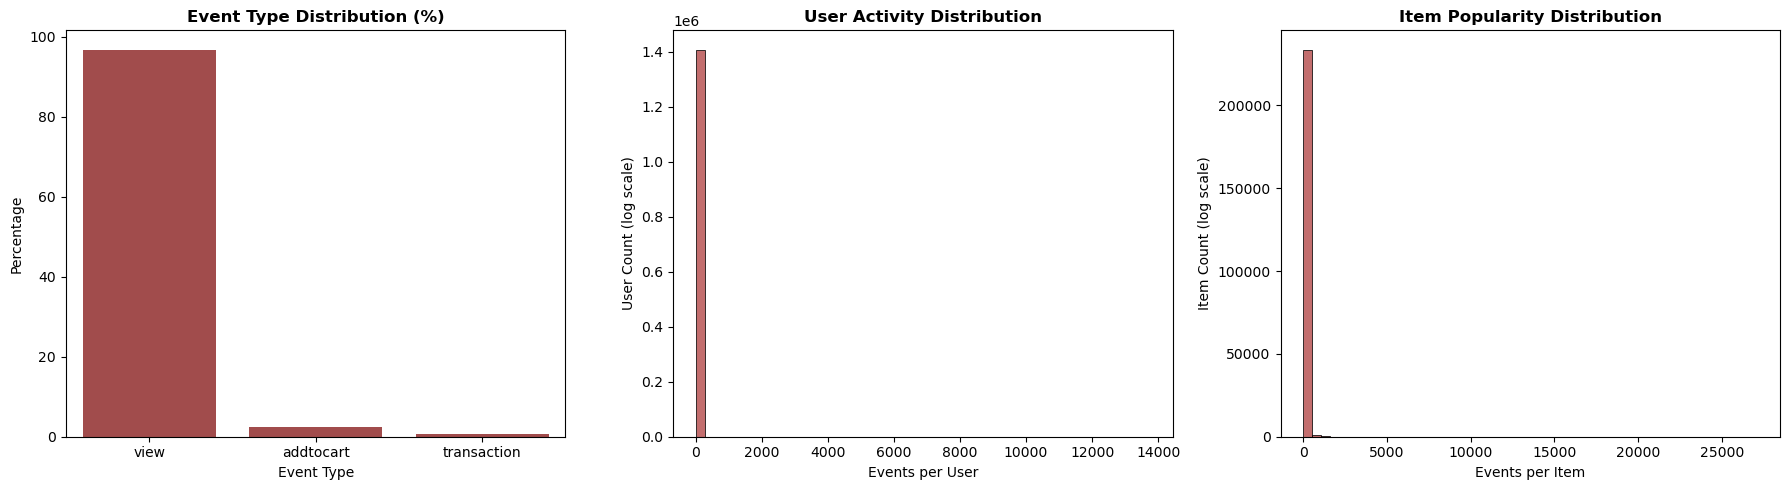

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom color palette
custom_colors = ['#AF3E3E', '#CD5656', '#E55050', '#DA6C6C', '#F49BAB', '#FFE1E0']
sns.set_palette(sns.color_palette(custom_colors))

# 1️⃣ Event type distribution (percentage)
event_dist = events_t['event'].value_counts(normalize=True) * 100

# 2️⃣ User activity (number of events per user)
user_activity = events_t.groupby('visitorid').size()

# 3️⃣ Item popularity (number of events per item)
item_popularity = events_t.groupby('itemid').size()

# Print summaries
print("📌 Event Type Distribution (%)\n", event_dist, "\n")
print("📌 User Activity Stats\n", user_activity.describe(), "\n")
print("📌 Item Popularity Stats\n", item_popularity.describe(), "\n")

# ---------- Visualization ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Event distribution (bar plot)
sns.barplot(x=event_dist.index, y=event_dist.values, ax=axes[0])
axes[0].set_title("Event Type Distribution (%)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Event Type")

# User activity (histogram)
sns.histplot(user_activity, bins=50, ax=axes[1])
axes[1].set_title("User Activity Distribution", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Events per User")
axes[1].set_ylabel("User Count (log scale)")

# Item popularity (histogram)
sns.histplot(item_popularity, bins=50, ax=axes[2])
axes[2].set_title("Item Popularity Distribution", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Events per Item")
axes[2].set_ylabel("Item Count (log scale)")

plt.tight_layout()
plt.show()


1. Event Type Distribution
   - Huge imbalance — almost everything is a "view" event. This is normal in e-commerce: most users browse but few add to cart or buy.
   - It means the recommendation model will need to handle class imbalance or implicit feedback (views imply interest, even without a purchase).

2.  User Activity
   - Most users are one-time visitors.
   - A few users are extremely active (potentially bots, crawlers, or power shoppers).
   - Before modelling:
        - Remove obvious bots/outliers (e.g., >5,000 events in 4.5 months)
        - Or treat them separately so they don’t dominate recommendations

3.  Item Popularity
    - Many items are rarely interacted with (long tail problem). A few are super popular — this can bias simple models towards “best-sellers.”

### ***B. Remove extreme outliers (users and items)***

In [15]:
# 1.1 compute activity/popularity series (if not already present)
user_activity = events_t.groupby('visitorid').size()
item_popularity = events_t.groupby('itemid').size()

# 1.2 show quantiles to inspect and decide
qs = [0.90, 0.95, 0.99, 0.995, 0.999]
print("User activity quantiles:")
print(user_activity.quantile(qs).astype(int))
print("\nItem popularity quantiles:")
print(item_popularity.quantile(qs).astype(int))

# 1.3 choose thresholds (default: 99.9th percentile)
user_thresh = int(user_activity.quantile(0.999))
item_thresh = int(item_popularity.quantile(0.999))
print(f"\nUsing thresholds -> user_thresh: {user_thresh}, item_thresh: {item_thresh}")

# 1.4 apply filters and report
initial_rows = len(events_t)
valid_users = user_activity[user_activity <= user_thresh].index
valid_items = item_popularity[item_popularity <= item_thresh].index

events_filtered = events_t[events_t['visitorid'].isin(valid_users) & events_t['itemid'].isin(valid_items)].copy()
print(f"Dropped rows: {initial_rows - len(events_filtered)}  ({(initial_rows - len(events_filtered))/initial_rows:.2%})")
print("Remaining rows:", len(events_filtered))


User activity quantiles:
0.900      8
0.950     18
0.990     43
0.995     72
0.999    163
dtype: int32

Item popularity quantiles:
0.900      36
0.950      73
0.990     360
0.995     666
0.999    2302
dtype: int32

Using thresholds -> user_thresh: 163, item_thresh: 2302
Dropped rows: 1472348  (24.95%)
Remaining rows: 4427915


### ***C. Handle the categoryid NaNs in events_t***

In [16]:
# checking for NaNs
events_t.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    5856136
categoryid        255585
has_cat                0
dtype: int64

In [17]:
# 2.1 show how many NaNs exist currently (on filtered data)
print("categoryid NaNs before handling:", events_filtered['categoryid'].isna().sum(),
      "of", len(events_filtered), f"({events_filtered['categoryid'].isna().mean():.2%})")

# 2.2 create final category column and flag
events_filtered['categoryid_final'] = events_filtered['categoryid'].fillna(-1).astype('Int64')
events_filtered['category_known'] = events_filtered['categoryid_final'] != -1

# 2.3 report breakdown
print("Known categories:", events_filtered['category_known'].sum(),
      "Unknown categories:", (~events_filtered['category_known']).sum())


categoryid NaNs before handling: 246489 of 4427915 (5.57%)
Known categories: 4181426 Unknown categories: 246489


- ✅ 94.43% of events have a known category already.
- ❗ 5.57% are missing — these could be discontinued items, system glitches, or newly added products that never had a category assigned.
- They’ve now been isolated (via the category_known flag) so they won’t break anything later.

## **Feature Engineering**

### ***Merge with Category Tree***

In [18]:
category_tree = pd.read_csv("category_tree.csv")
print(category_tree.columns)
category_tree.head()

Index(['categoryid', 'parentid'], dtype='object')


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [19]:
# Merge events with category tree
events_enriched = events_filtered.merge(
    category_tree,
    how='left',
    left_on='categoryid_final',  # this must exist in events_filtered
    right_on='categoryid'
)

# Check what columns exist after merge
print(events_enriched.columns)

# If parentid exists, great — if not, check for suffixed versions
if 'parentid' not in events_enriched.columns:
    possible_parent_cols = [col for col in events_enriched.columns if 'parentid' in col]
    print("Possible parentid columns found:", possible_parent_cols)
    if possible_parent_cols:
        events_enriched['parentid'] = events_enriched[possible_parent_cols[0]]

# Now safely fill NaNs
events_enriched['parentid'] = events_enriched['parentid'].fillna(-1).astype('Int64')
 

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid',
       'categoryid_x', 'has_cat', 'categoryid_final', 'category_known',
       'categoryid_y', 'parentid'],
      dtype='object')


In [20]:
# --- Merge events with category_tree to get parentid ---
events_enriched = events_filtered.merge(
    category_tree[['categoryid', 'parentid']],  # only required columns
    how='left',
    left_on='categoryid_final',
    right_on='categoryid',
    suffixes=('', '_tree')
)

# Fill missing parentid with -1 (root/no parent)
events_enriched['parentid'] = events_enriched['parentid'].fillna(-1).astype('Int64')

# Drop the categoryid from tree (duplicate)
events_enriched = events_enriched.drop(columns=['categoryid_tree'])

# --- Compute category depth ---
def compute_category_depth(tree_df):
    """Returns a dictionary mapping categoryid → depth."""
    depth_map = {}
    
    def get_depth(cat_id):
        if cat_id == -1 or pd.isna(cat_id):
            return 0
        parent = tree_df.loc[tree_df['categoryid'] == cat_id, 'parentid']
        if parent.empty:
            return 0
        parent_id = parent.values[0]
        return 1 + get_depth(parent_id)
    
    for cid in tree_df['categoryid']:
        depth_map[cid] = get_depth(cid)
    
    return depth_map

# Generate depth mapping from category_tree
depth_mapping = compute_category_depth(category_tree)

# Map depth into events_enriched
events_enriched['category_depth'] = events_enriched['categoryid_final'].map(depth_mapping).fillna(0).astype(int)

print(events_enriched[['categoryid_final', 'parentid', 'category_depth']].head())


   categoryid_final  parentid  category_depth
0              1171       938               4
1              1171       938               4
2              1038      1174               4
3              1038      1174               4
4              1038      1174               4


In [21]:
events_enriched.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,has_cat,categoryid_final,category_known,parentid,category_depth
0,1439922640493,370720.0,view,3,NaN,1171.0,1.0,1171,True,938,4
1,1441031942792,639016.0,view,3,NaN,1171.0,1.0,1171,True,938,4
2,1435647791545,1042455.0,view,4,NaN,1038.0,1.0,1038,True,1174,4
3,1441044360244,905555.0,view,4,NaN,1038.0,1.0,1038,True,1174,4
4,1442359364099,1010132.0,view,4,NaN,1038.0,1.0,1038,True,1174,4


In [25]:

# 1️⃣ Encode user and item IDs
user_enc = LabelEncoder()
item_enc = LabelEncoder()

events_enriched['user_id'] = user_enc.fit_transform(events_enriched['visitorid'])
events_enriched['item_id'] = item_enc.fit_transform(events_enriched['itemid'])


In [26]:
# 2️⃣ Define interaction weights
event_weights = {
    'view': 1,
    'addtocart': 3,
    'transaction': 5
}

# Map event types to weights
events_enriched['event_weight'] = events_enriched['event'].map(event_weights)



In [27]:
# Check if the key columns exist and have the right types
print(events_enriched[['user_id', 'item_id', 'event_weight']].head())
print(events_enriched[['user_id', 'item_id', 'event_weight']].isna().sum())

# Make sure user_id and item_id are integers and >= 0
print(events_enriched['user_id'].min(), events_enriched['item_id'].min())

# Check shape to make sure the DataFrame is not empty
print("Events enriched shape:", events_enriched.shape)


   user_id  item_id  event_weight
0   362737        0             1
1   625089        0             1
2  1019791        1             1
3   885825        1             1
4   988123        1             1
user_id         0
item_id         0
event_weight    0
dtype: int64
0 0
Events enriched shape: (4427915, 14)


In [28]:
# Ensure timestamp is in datetime format
events_enriched['timestamp'] = pd.to_datetime(events_enriched['timestamp'], unit='ms', errors='coerce')

# Extract hour & day of week
events_enriched['hour'] = events_enriched['timestamp'].dt.hour
events_enriched['day_of_week'] = events_enriched['timestamp'].dt.day_name()

# Extract just the date
events_enriched['date'] = events_enriched['timestamp'].dt.date

# Count unique days each user appeared
user_days = events_enriched.groupby('visitorid')['date'].nunique().reset_index(name='active_days')




### **Data Visualisation**

### 1️⃣ Time-Based Trends – Interactions Over Time
- Goal: Show how activity changes daily, weekly, or monthly.

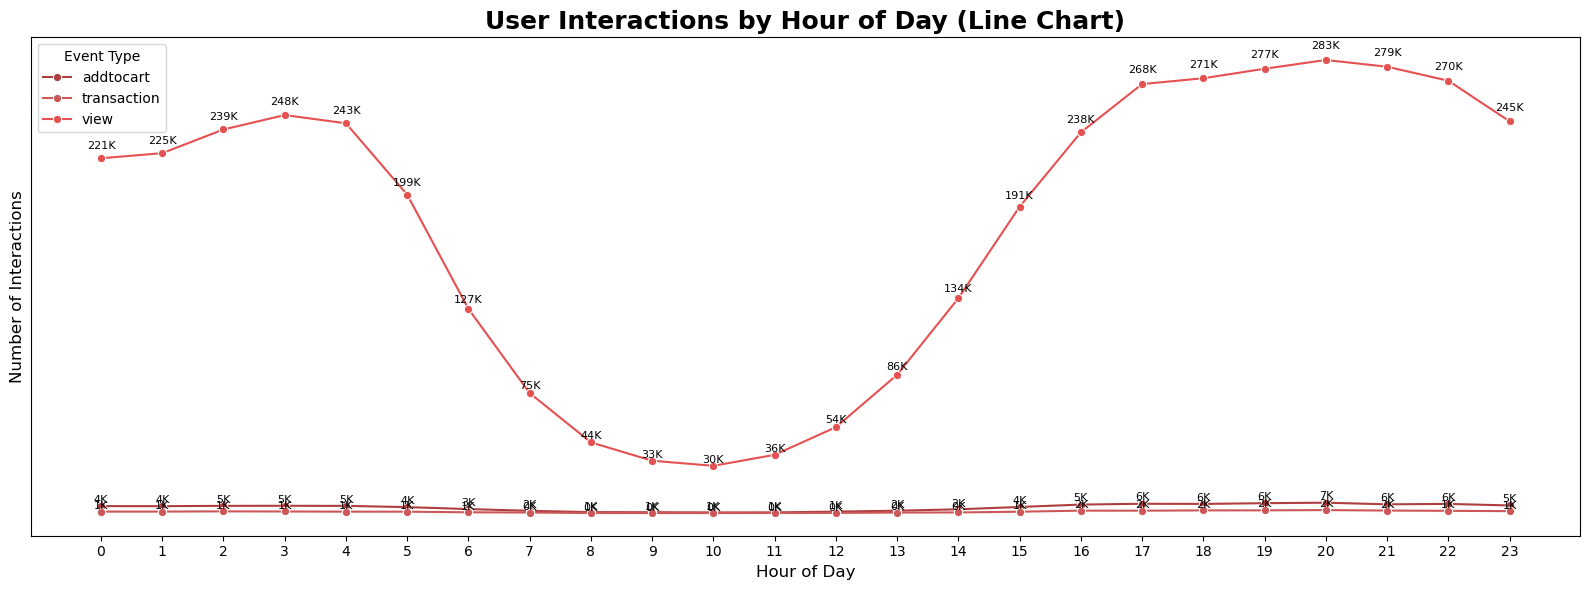

In [29]:
# Prepare data
hour_event_counts = events_enriched.groupby(['hour', 'event']).size().reset_index(name='count')

# Custom colors
custom_colors = ['#AF3E3E', '#CD5656', '#E55050']

plt.figure(figsize=(16,6))
ax = sns.lineplot(
    data=hour_event_counts,
    x='hour',
    y='count',
    hue='event',
    marker='o',
    palette=custom_colors
)

# Different vertical offsets for each event type
offset_map = {
    'view': 0.02,         # small offset for big values
    'addtocart': 0.15,    # higher offset so they don't clash
    'transaction': 0.30   # even higher offset
}

# Add rounded integer labels without overlap
for event in hour_event_counts['event'].unique():
    subset = hour_event_counts[hour_event_counts['event'] == event]
    for x, y in zip(subset['hour'], subset['count']):
        ax.text(
            x, y + (y * offset_map[event]),
            f"{round(y/1000)}K",
            ha='center', va='bottom', fontsize=8
        )

# Style
ax.set_ylabel("Number of Interactions", fontsize=12)
ax.set_xlabel("Hour of Day", fontsize=12)
ax.set_xticks(range(0,24))
ax.set_yticks([])
plt.title("User Interactions by Hour of Day (Line Chart)", fontsize=18, fontweight='bold')
plt.legend(title="Event Type")
plt.tight_layout()
plt.show()


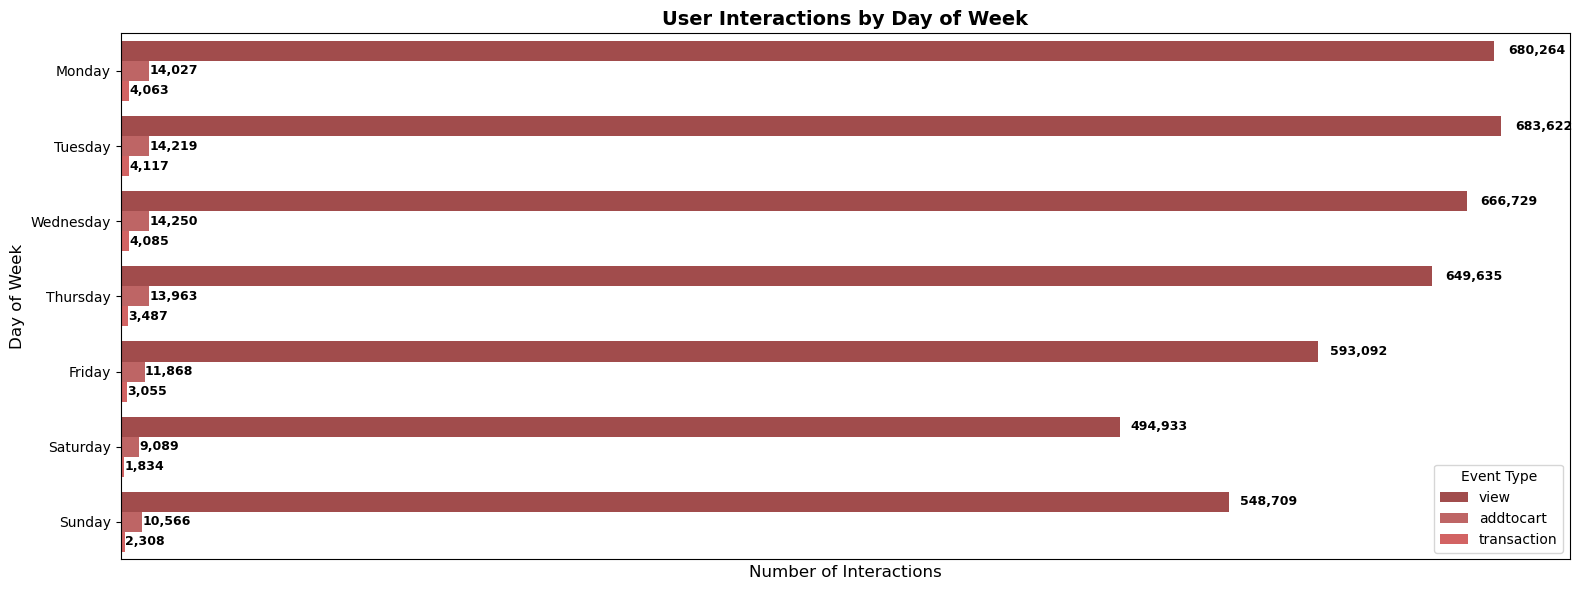

In [30]:
# ---- Horizontal Bar Chart: Day-of-week distribution ----
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(16,6))
custom_colors = ['#AF3E3E', '#CD5656', '#E55050']  # One color per event type
sns.set_palette(sns.color_palette(custom_colors))

ax = sns.countplot(
    data=events_enriched,
    y='day_of_week',
    hue='event',
    order=day_order,
    orient='h'
)

# Add cleaner data labels (rounded to nearest whole number)
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        label = f'{int(round(width, 0)):,}'  # Whole number with commas
        ax.annotate(label,
                    (width + (0.01 * width), p.get_y() + p.get_height()/2),
                    ha='left', va='center', fontsize=9, fontweight='bold')

# Style adjustments
ax.set_xlabel("Number of Interactions", fontsize=12)
ax.set_ylabel("Day of Week", fontsize=12)
ax.set_xticks([])  # Remove ticks but keep axis label
plt.title("User Interactions by Day of Week", fontsize=14, fontweight='bold')
plt.legend(title="Event Type")
plt.tight_layout()
plt.show()


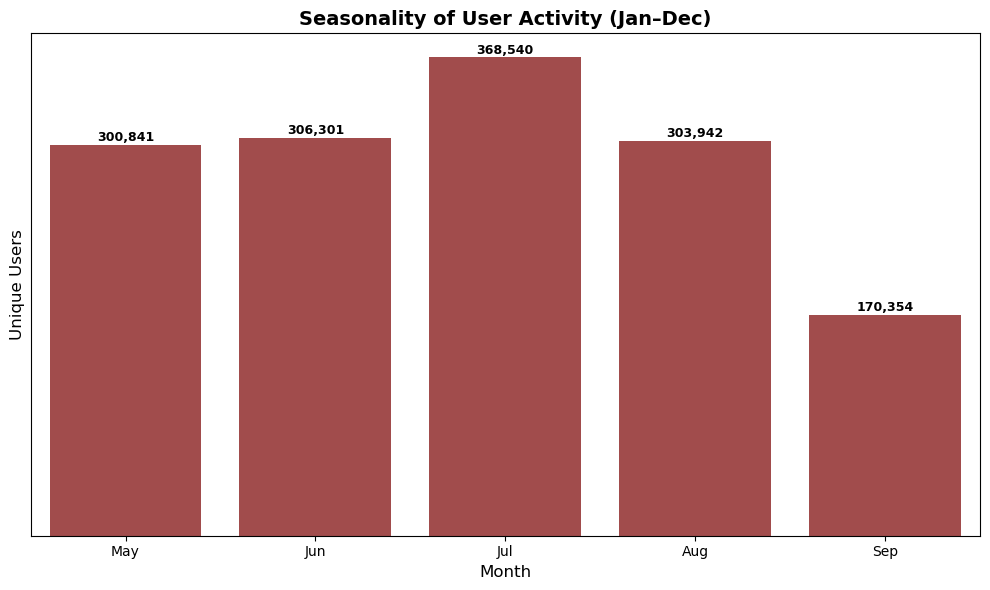

In [43]:
# --- Seasonality: User Interactions by Month (Jan–Dec) ---
import calendar

# Extract month from timestamp
events_enriched['month'] = events_enriched['timestamp'].dt.month

# Count interactions by month (unique users)
month_counts = events_enriched.groupby('month')['visitorid'].nunique().reset_index()
month_counts['month_name'] = month_counts['month'].apply(lambda x: calendar.month_abbr[x])

# Convert to int (remove decimals)
month_counts['visitorid'] = month_counts['visitorid'].astype(int)

# Plot
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette(custom_colors))

ax = sns.barplot(data=month_counts, x='month_name', y='visitorid')

# Data labels (force integer formatting)
for p in ax.patches:
    height = int(p.get_height())  # convert to int
    ax.annotate(f"{height:,}", 
                (p.get_x() + p.get_width()/2, height + 500), 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel("Unique Users", fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.set_yticks([])
plt.title("Seasonality of User Activity (Jan–Dec)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 2️⃣ Category-Level Popularity
- Goal: See which categories dominate user interactions.

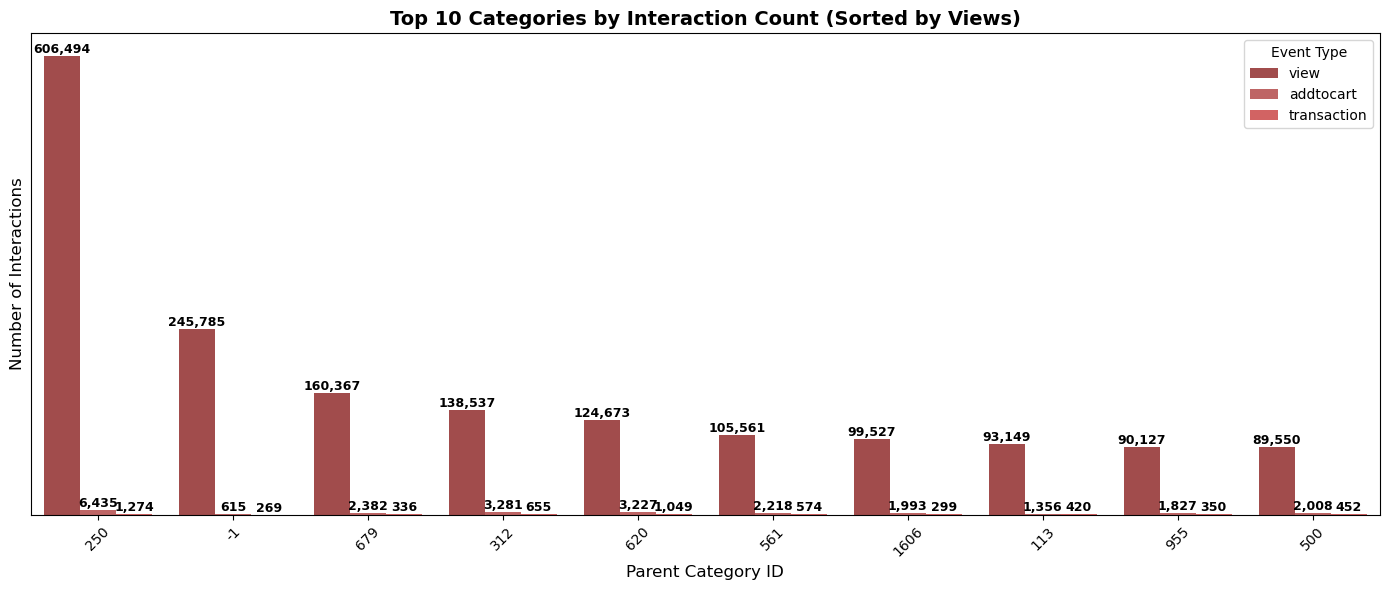

In [44]:
# ---- Top 10 Categories by Interaction Count (sorted by views first) ----
import matplotlib.pyplot as plt
import seaborn as sns

# Custom palette
custom_colors = ['#AF3E3E', '#CD5656', '#E55050', '#DA6C6C', '#F49BAB', '#FFE1E0']
sns.set_palette(sns.color_palette(custom_colors))

# Aggregate by category
cat_popularity = events_enriched.groupby(['parentid', 'event']).size().reset_index(name='count')

# Sort so 'view' comes first in hue order
event_order = ['view', 'addtocart', 'transaction']

# Get top 10 categories based on total counts
top_cats = cat_popularity.groupby('parentid')['count'].sum().nlargest(10).index
cat_popularity_top = cat_popularity[cat_popularity['parentid'].isin(top_cats)]

# Sort parentid order by number of views (descending)
view_order = (
    cat_popularity_top[cat_popularity_top['event'] == 'view']
    .sort_values('count', ascending=False)['parentid']
    .tolist()
)

plt.figure(figsize=(14,6))
ax = sns.barplot(
    data=cat_popularity_top,
    x='parentid',
    y='count',
    hue='event',
    hue_order=event_order,   # ensures 'view' is always first
    order=view_order,        # ensures categories sorted by view count
    palette=custom_colors
)

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height):,}',
                    (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel("Number of Interactions", fontsize=12)
ax.set_xlabel("Parent Category ID", fontsize=12)
ax.set_yticks([])  # Remove tick marks but keep axis title
plt.title("Top 10 Categories by Interaction Count (Sorted by Views)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Event Type")
plt.tight_layout()
plt.show()


### 3️⃣ Repeat User Behavior
- Goal: Measure customer retention and repeat purchases.

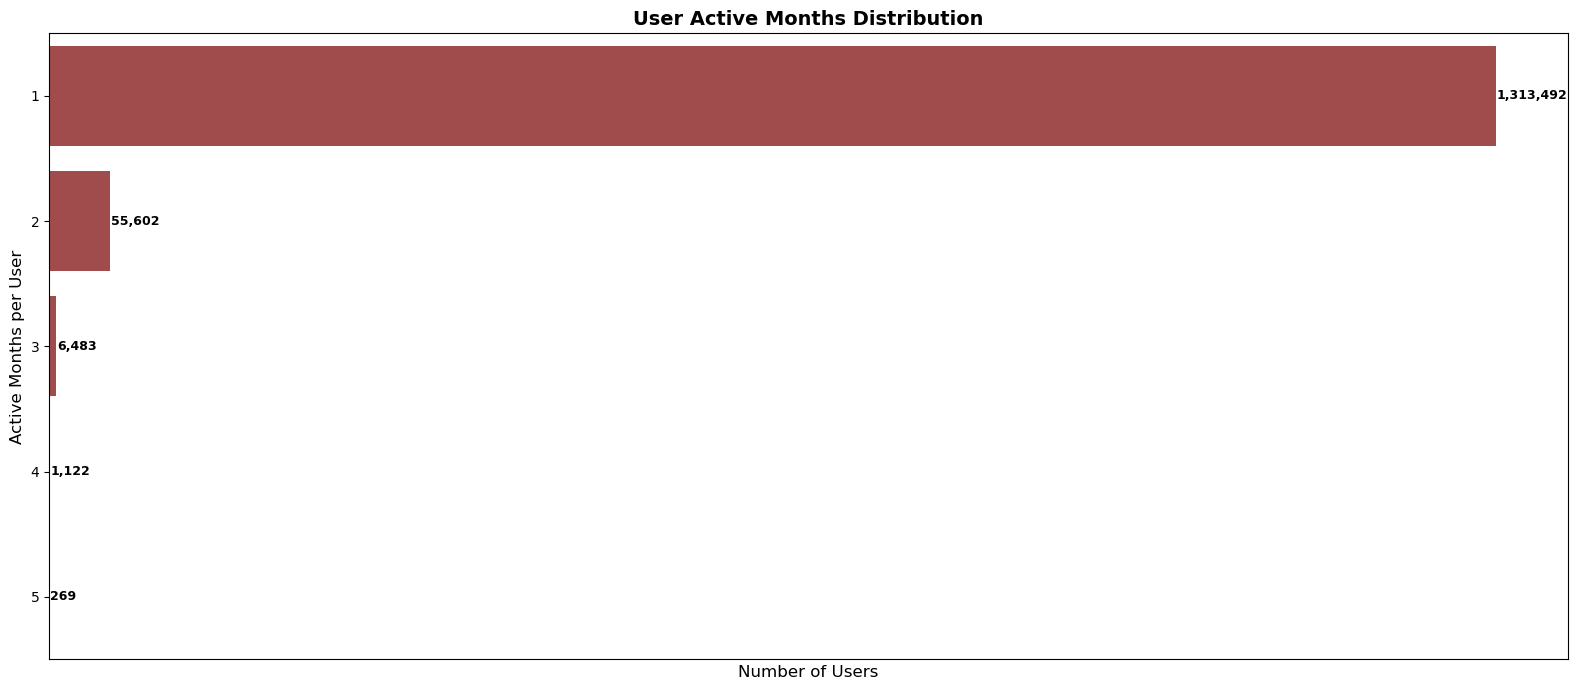

In [45]:
# --- User Active Months Distribution (Better Visualization, Integer Labels) ---

# Extract month names from timestamp
events_enriched['month'] = events_enriched['timestamp'].dt.month_name()

# Count unique months each user was active
user_months = events_enriched.groupby('visitorid')['month'].nunique().reset_index(name='active_months')

# Prepare frequency table
month_counts = user_months['active_months'].value_counts().reset_index()
month_counts.columns = ['active_months', 'num_users']
month_counts = month_counts.sort_values('active_months')

# Plot as horizontal bar chart
plt.figure(figsize=(16,7))
sns.set_palette(sns.color_palette(custom_colors))

ax = sns.barplot(
    data=month_counts,
    y='active_months',
    x='num_users',
    orient='h'
)

# Add integer data labels to the right of bars
for p in ax.patches:
    width = int(p.get_width())  # force integer
    ax.annotate(f"{width:,}", 
                (width + 500, p.get_y() + p.get_height()/2), 
                ha='left', va='center', fontsize=9, fontweight='bold')

# Styling
ax.set_xlabel("Number of Users", fontsize=12)
ax.set_ylabel("Active Months per User", fontsize=12)
ax.set_xticks([])  # Remove ticks but keep axis label
plt.title("User Active Months Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


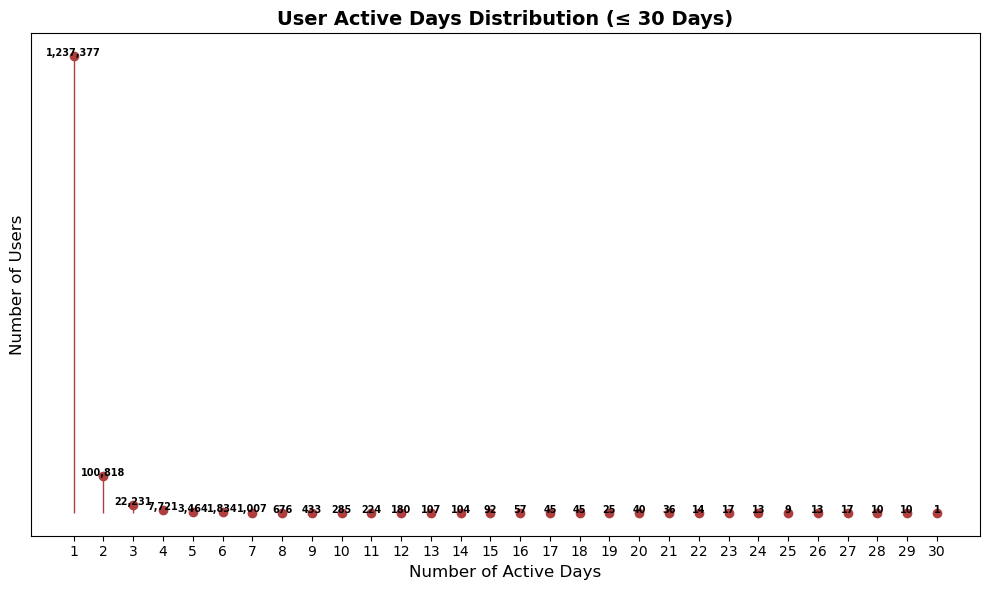

In [46]:
# Prepare frequency table
active_day_counts = user_days['active_days'].value_counts().reset_index()
active_day_counts.columns = ['active_days', 'num_users']
active_day_counts = active_day_counts.sort_values('active_days')

# Limit to ≤ 30 days for clarity
active_day_counts = active_day_counts[active_day_counts['active_days'] <= 30]

# Lollipop chart
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette(custom_colors))

# Plot stems (compatible with older matplotlib)
markerline, stemlines, baseline = plt.stem(
    active_day_counts['active_days'], 
    active_day_counts['num_users'], 
    linefmt='-', markerfmt='o', basefmt=" "
)

# Style stems
plt.setp(markerline, markersize=6)
plt.setp(stemlines, linewidth=1)

# Data labels
for i, row in active_day_counts.iterrows():
    plt.text(row['active_days'], row['num_users'] + 100, f"{row['num_users']:,}",
             ha='center', fontsize=7, fontweight='bold')

# Styling
plt.ylabel("Number of Users", fontsize=12)
plt.xlabel("Number of Active Days", fontsize=12)
plt.xticks(active_day_counts['active_days'])
plt.yticks([])  # Remove y-axis ticks but keep label
plt.title("User Active Days Distribution (≤ 30 Days)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


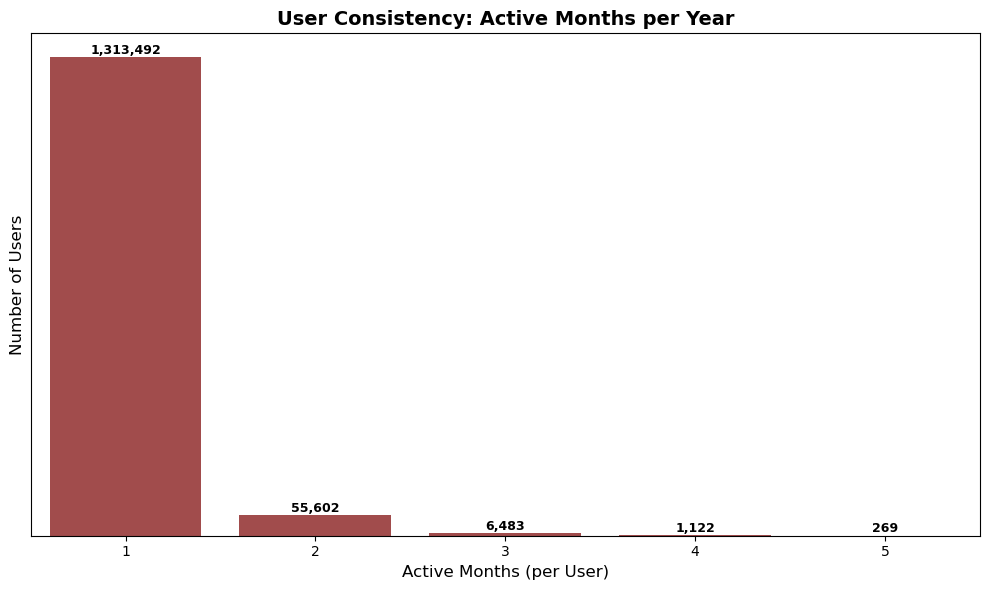

In [47]:
# --- User Consistency: How many months per year a user was active ---
# Extract year-month for each event
events_enriched['year_month'] = events_enriched['timestamp'].dt.to_period('M')

# Count unique months per user
user_months = events_enriched.groupby('visitorid')['year_month'].nunique().reset_index(name='active_months')

# Frequency table
month_active_counts = user_months['active_months'].value_counts().reset_index()
month_active_counts.columns = ['active_months', 'num_users']
month_active_counts = month_active_counts.sort_values('active_months')

# Convert to int for clean display
month_active_counts['num_users'] = month_active_counts['num_users'].astype(int)

# Plot
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette(custom_colors))

ax = sns.barplot(data=month_active_counts, x='active_months', y='num_users')

# Data labels (as integers with comma formatting)
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", 
                (p.get_x() + p.get_width()/2, height + 500), 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel("Number of Users", fontsize=12)
ax.set_xlabel("Active Months (per User)", fontsize=12)
ax.set_yticks([])
plt.title("User Consistency: Active Months per Year", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 4️⃣ Conversion Funnel
- Goal: Understand the drop-off from viewing → adding to cart → purchasing.

📌 View → Cart conversion rate: 2.61%
📌 Cart → Purchase conversion rate: 30.85%


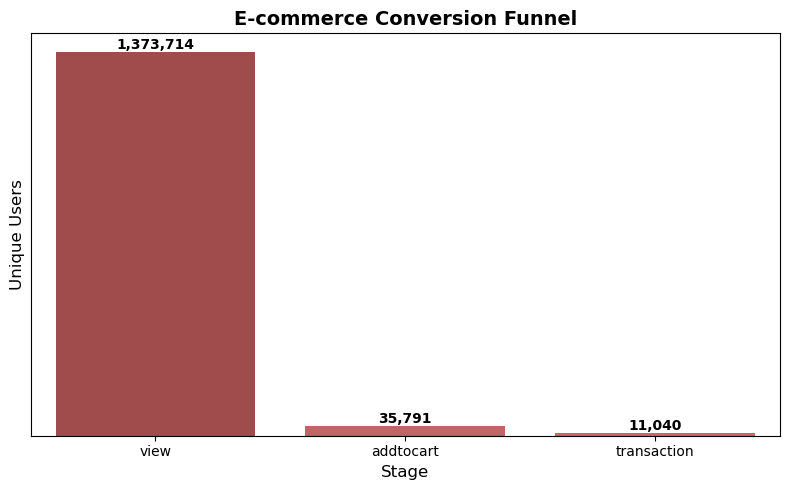

In [48]:
# Count unique users per stage
funnel = events_enriched.groupby('event')['visitorid'].nunique().reindex(['view', 'addtocart', 'transaction'])

# Conversion rates
view_to_cart = (funnel['addtocart'] / funnel['view']) * 100
cart_to_purchase = (funnel['transaction'] / funnel['addtocart']) * 100

print(f"📌 View → Cart conversion rate: {view_to_cart:.2f}%")
print(f"📌 Cart → Purchase conversion rate: {cart_to_purchase:.2f}%")

# Custom palette
custom_colors = ['#AF3E3E', '#CD5656', '#E55050']

# Funnel plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x=funnel.index, y=funnel.values, palette=custom_colors)

# Add data labels on bars (integer formatting with commas)
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}', 
                (p.get_x() + p.get_width()/2, height), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
ax.set_ylabel("Unique Users", fontsize=12)
ax.set_xlabel("Stage", fontsize=12)
ax.set_yticks([])  # Remove ticks but keep label
plt.title("E-commerce Conversion Funnel", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [37]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix
import numpy as np
import pandas as pd

# 1️⃣ Encode user and item IDs
user_enc = LabelEncoder()
item_enc = LabelEncoder()

events_enriched['user_id'] = user_enc.fit_transform(events_enriched['visitorid'])
events_enriched['item_id'] = item_enc.fit_transform(events_enriched['itemid'])

# 2️⃣ Define interaction weights
event_weights = {
    'view': 1,
    'addtocart': 3,
    'transaction': 5
}

# Map event types to weights
events_enriched['event_weight'] = events_enriched['event'].map(event_weights)

# 3️⃣ Create a sparse interaction matrix for modelling
rows = events_enriched['user_id'].values
cols = events_enriched['item_id'].values
data = events_enriched['event_weight'].values

interaction_sparse = coo_matrix(
    (data, (rows, cols)),
    shape=(
        events_enriched['user_id'].nunique(),
        events_enriched['item_id'].nunique()
    )
)

print(f"✅ Sparse matrix created: {interaction_sparse.shape}, {interaction_sparse.nnz} interactions")
print(f"Memory usage (dense) would be ~{interaction_sparse.shape[0] * interaction_sparse.shape[1] * 8 / 1e9:.2f} GB!")

import os
os.makedirs("data", exist_ok=True)  # Creates the folder if it doesn't exist

import pickle
with open("data/interaction_sparse.pkl", "wb") as f:
    pickle.dump(interaction_sparse, f)

# Optional: save for modelling
import pickle
with open("data/interaction_sparse.pkl", "wb") as f:
    pickle.dump(interaction_sparse, f)

# 4️⃣ Small dense pivot preview for EDA (only sample users/items)
sample_users = np.random.choice(events_enriched['user_id'].unique(), size=10, replace=False)
sample_items = np.random.choice(events_enriched['item_id'].unique(), size=10, replace=False)

preview_df = events_enriched[
    events_enriched['user_id'].isin(sample_users) &
    events_enriched['item_id'].isin(sample_items)
]

interaction_preview = pd.pivot_table(
    preview_df,
    index='user_id',
    columns='item_id',
    values='event_weight',
    aggfunc='max',
    fill_value=0
)

print("\n🔍 Interaction Matrix Preview (sampled):")
print(interaction_preview)


✅ Sparse matrix created: (1376968, 230615), 4427915 interactions
Memory usage (dense) would be ~2540.40 GB!

🔍 Interaction Matrix Preview (sampled):
Empty DataFrame
Columns: []
Index: []


In [38]:
# Keep only transaction events
transactions_only = events_enriched[events_enriched['event'] == 'transaction'].copy()

# Drop unnecessary columns if needed (keep key IDs for linking)
transactions_only = transactions_only[['timestamp', 'visitorid', 'itemid', 'transactionid', 'categoryid_final']]

# Save for later funnel/conversion analysis
import os
os.makedirs("data/eda", exist_ok=True)
transactions_only.to_csv("data/eda/transactions_only.csv", index=False)

print(f"✅ Saved {len(transactions_only):,} purchase records for later analysis.")


✅ Saved 22,949 purchase records for later analysis.


In [39]:
# 1️⃣ Keep a copy for funnel analysis
transactions_only = events_enriched[events_enriched['event'] == 'transaction'].copy()

# 2️⃣ Drop it from modelling dataset
if 'transactionid' in events_enriched.columns:
    events_enriched = events_enriched.drop(columns=['transactionid'])

print("transactionid removed from modelling dataset.")
print("transactions_only shape:", transactions_only.shape)

transactionid removed from modelling dataset.
transactions_only shape: (22949, 19)


In [40]:
events_enriched.head()

,timestamp,visitorid,event,itemid,categoryid,has_cat,categoryid_final,category_known,parentid,category_depth,event_weight,user_id,item_id,hour,day_of_week,date,month,year_month
0,2015-08-18 18:30:40.493,370720.0,view,3,1171.0,1.0,1171,True,938,4,1,362737,0,18,Tuesday,2015-08-18,August,2015-08
1,2015-08-31 14:39:02.792,639016.0,view,3,1171.0,1.0,1171,True,938,4,1,625089,0,14,Monday,2015-08-31,August,2015-08
2,2015-06-30 07:03:11.545,1042455.0,view,4,1038.0,1.0,1038,True,1174,4,1,1019791,1,7,Tuesday,2015-06-30,June,2015-06
3,2015-08-31 18:06:00.244,905555.0,view,4,1038.0,1.0,1038,True,1174,4,1,885825,1,18,Monday,2015-08-31,August,2015-08
4,2015-09-15 23:22:44.099,1010132.0,view,4,1038.0,1.0,1038,True,1174,4,1,988123,1,23,Tuesday,2015-09-15,September,2015-09


In [49]:
# === Export cell: standardize events_enriched, create df, sample and GitHub friendly shards ===
import pandas as pd, numpy as np, pathlib, os, glob

# 0 checks
assert "events_enriched" in globals(), "events_enriched is not in memory"
req = {"timestamp","visitorid","event","itemid","categoryid_final"}
missing = req - set(events_enriched.columns)
assert not missing, f"events_enriched is missing columns: {missing}"

# 1 standardize into df
df = events_enriched[["timestamp","visitorid","event","itemid","categoryid_final"]].copy()

# timestamp to int milliseconds for stability across platforms
if np.issubdtype(df["timestamp"].dtype, np.datetime64):
    df["timestamp"] = (df["timestamp"].astype("int64") // 1_000_000).astype("int64")
else:
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce").astype("int64")

df = df.dropna(subset=["categoryid_final"]).astype({
    "visitorid": "int64",
    "itemid": "int64",
    "categoryid_final": "int64"
}).sort_values(["visitorid","timestamp"]).reset_index(drop=True)

print("Event counts:\n", df["event"].value_counts())

# 2 output folder
root = pathlib.Path("recsys_items")
root.mkdir(exist_ok=True)

# 3 write a strong public sample that contains active users with views
views = df[df["event"] == "view"]
top_users = (views.groupby("visitorid").size()
                   .sort_values(ascending=False)
                   .head(200).index)

sample = df[df["visitorid"].isin(top_users)][
    ["timestamp","visitorid","event","categoryid_final"]
].copy()

sample_csv = root / "sample_events.csv"
sample_parq = root / "sample_events.parquet"
sample.to_csv(sample_csv, index=False)
sample.to_parquet(sample_parq, index=False, compression="snappy")
print(f"Wrote sample CSV rows={len(sample):,} users={sample['visitorid'].nunique():,} -> {sample_csv}")
print(f"Wrote sample PARQUET -> {sample_parq}")

# 4 write compressed shards for GitHub with snappy compression
#    we adapt shard count if any shard exceeds about 90 MB
def write_shards(df_in: pd.DataFrame, base: pathlib.Path, target_mb: float = 90.0, max_shards: int = 16):
    # start with four shards and increase if needed
    N = 4
    while True:
        # clean old outputs for this N
        for old in base.parent.glob("events_enriched_part*.parquet"):
            try:
                old.unlink()
            except Exception:
                pass

        tmp = df_in.copy()
        tmp["_bucket"] = (tmp["visitorid"] % N).astype(int)
        sizes = []
        for b in range(N):
            part = tmp[tmp["_bucket"] == b].drop(columns=["_bucket"])
            if part.empty:
                continue
            fn = base.parent / f"events_enriched_part{b+1}.parquet"
            part.to_parquet(fn, index=False, compression="snappy")
            sz_mb = os.path.getsize(fn) / (1024**2)
            sizes.append(sz_mb)
            print(f"wrote {fn.name} size={sz_mb:.2f} MB rows={len(part):,}")
        if sizes and max(sizes) > target_mb and N < max_shards:
            N *= 2
            print(f"Largest shard {max(sizes):.2f} MB exceeds target {target_mb} MB. Increasing shards to N={N} and retrying...")
            continue
        break

write_shards(df[["timestamp","visitorid","event","categoryid_final"]], root / "events_enriched_part1.parquet")

print("\nShard files present:")
for p in sorted(glob.glob(str(root / "events_enriched_part*.parquet"))):
    print(" ", p)


Event counts:
 event
view           4316984
addtocart        87982
transaction      22949
Name: count, dtype: int64
Wrote sample CSV rows=30,064 users=200 -> recsys_items\sample_events.csv
Wrote sample PARQUET -> recsys_items\sample_events.parquet
wrote events_enriched_part1.parquet size=7.70 MB rows=1,100,194
wrote events_enriched_part2.parquet size=7.72 MB rows=1,109,931
wrote events_enriched_part3.parquet size=7.72 MB rows=1,107,738
wrote events_enriched_part4.parquet size=7.75 MB rows=1,110,052

Shard files present:
  recsys_items\events_enriched_part1.parquet
  recsys_items\events_enriched_part2.parquet
  recsys_items\events_enriched_part3.parquet
  recsys_items\events_enriched_part4.parquet


## **Feature Engineering**

### **T1.0 Prepare the modelling frame**

In [51]:
import pandas as pd, numpy as np

# df built from events_enriched with the columns you showed
df = events_enriched[["timestamp","visitorid","event","itemid","categoryid_final"]].copy()

# timestamp as int ms (stable for parquet/csv)
if np.issubdtype(df["timestamp"].dtype, np.datetime64):
    df["timestamp"] = (df["timestamp"].astype("int64") // 1_000_000).astype("int64")
else:
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce").astype("int64")

# enforce types and keep the expected column name categoryid_final
df = df.dropna(subset=["categoryid_final"]).astype({
    "visitorid":"int64",
    "itemid":"int64",
    "categoryid_final":"int64"
})
df = df.sort_values(["visitorid","timestamp"]).reset_index(drop=True)

print(df.event.value_counts())     # quick sanity
df.head(3)


event
view           4316984
addtocart        87982
transaction      22949
Name: count, dtype: int64


,timestamp,visitorid,event,itemid,categoryid_final
0,1442004589439,0,view,285930,1188
1,1442004759591,0,view,357564,256
2,1442004917175,0,view,67045,333


### **T1.1 Feature builder from preceding views**

In [54]:
from collections import Counter
import numpy as np

def build_task1_from_views(events_df: pd.DataFrame,
                           views_lookback: int = 50,
                           time_window_sec: int = 24*60*60) -> pd.DataFrame:
    rows = []
    millis = time_window_sec * 1000

    views = events_df[events_df["event"]=="view"]
    adds  = events_df[events_df["event"]=="addtocart"]

    # group views by visitor for fast slicing
    g = views.groupby("visitorid", sort=False)

    for _, a in adds.iterrows():
        uid = a["visitorid"]; t = a["timestamp"]; tgt = int(a["categoryid_final"])
        if uid not in g.groups:
            continue

        v = g.get_group(uid)
        v = v[(v["timestamp"] < t) & (v["timestamp"] >= t - millis)]
        if v.empty:
            continue

        v = v.tail(views_lookback)
        cats = v["categoryid_final"].astype(int).tolist()
        if not cats:
            continue

        counts = Counter(cats)
        top_cat = max(counts, key=counts.get)
        top_share = counts[top_cat] / len(cats)
        diversity = len(counts)
        n_views = len(cats)
        last_gap_min = (t - v["timestamp"].iloc[-1]) / 60000.0

        ps = np.array(list(counts.values()), dtype=float) / n_views
        entropy = float(-(ps * np.log(ps + 1e-12)).sum())

        rows.append({
            "visitorid": uid,
            "timestamp": t,
            "target_category": tgt,
            "top_view_cat": int(top_cat),
            "top_view_share": top_share,
            "view_diversity": diversity,
            "n_views_window": n_views,
            "last_view_gap_min": last_gap_min,
            "entropy": entropy
        })
    return pd.DataFrame(rows)

task1_df = build_task1_from_views(df, views_lookback=50, time_window_sec=24*60*60)
print("Task 1 rows:", len(task1_df))
task1_df.head()


Task 1 rows: 74003


,visitorid,timestamp,target_category,top_view_cat,top_view_share,view_diversity,n_views_window,last_view_gap_min,entropy
0,150,1433719818230,577,577,1.000000,1,2,1.293850,-1.000089e-12
1,172,1439599816912,1219,1219,1.000000,1,1,1.065233,-1.000089e-12
2,172,1439601219691,196,196,0.833333,2,6,7.020883,4.505612e-01
3,172,1439601228324,196,196,0.833333,2,6,7.164767,4.505612e-01
4,177,1442290183293,1339,1339,1.000000,1,1,0.718150,-1.000089e-12


### **T1.2 Majority baseline**

In [55]:
def ensure_ts(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if np.issubdtype(out["timestamp"].dtype, np.datetime64):
        out["ts"] = pd.to_datetime(out["timestamp"])
    else:
        out["ts"] = pd.to_datetime(pd.to_numeric(out["timestamp"], errors="coerce"), unit="ms")
    return out

def build_candidate_ranking_df(events_df: pd.DataFrame,
                               time_window_sec: int = 24*60*60,
                               views_lookback: int = 100) -> pd.DataFrame:
    df0 = events_df[["timestamp","visitorid","event","itemid","categoryid_final"]].rename(
        columns={"categoryid_final":"categoryid"}
    ).dropna(subset=["categoryid"]).copy()
    df0["categoryid"] = df0["categoryid"].astype("int64")

    df = ensure_ts(df0).sort_values(["visitorid","ts"]).reset_index(drop=True)

    views = df[df.event == "view"][["visitorid","ts","categoryid"]].copy()
    adds  = df[df.event == "addtocart"][["visitorid","ts","categoryid"]].copy()

    g = views.groupby("visitorid", sort=False)
    window = pd.Timedelta(seconds=time_window_sec)

    rows = []
    for add_idx, (uid, t, tgt) in enumerate(adds.itertuples(index=False, name=None)):
        if uid not in g.groups: continue
        v = g.get_group(uid)
        vw = v[(v["ts"] < t) & (v["ts"] >= t - window)]
        if vw.empty: continue
        vw = vw.tail(views_lookback).copy()
        cats = vw["categoryid"].tolist()
        if not cats: continue

        counts = Counter(cats)
        n = len(cats)
        last_pos = {c: i for i, c in enumerate(cats)}
        last_cat = cats[-1]

        tail_streak = 1
        for i in range(n - 2, -1, -1):
            if cats[i] == last_cat: tail_streak += 1
            else: break

        for c, cnt in counts.items():
            li = last_pos[c]
            last_ts_c = vw.iloc[li]["ts"]
            last_gap_min = float((t - last_ts_c).total_seconds() / 60.0)
            rows.append({
                "add_id": int(add_idx),
                "visitorid": int(uid),
                "candidate_cat": int(c),
                "label": int(c == int(tgt)),
                "cnt": int(cnt),
                "share": cnt / n,
                "is_last": int(c == last_cat),
                "last_gap_min": last_gap_min,
                "pos_from_end": int(n - li),
                "tail_streak_if_last": int(tail_streak if c == last_cat else 0),
                "n_views": int(n)
            })
    return pd.DataFrame(rows)


In [56]:
ranking_df = build_candidate_ranking_df(
    events_enriched, time_window_sec=24*60*60, views_lookback=100
)
print("Ranking rows:", f"{len(ranking_df):,}", 
      "unique adds:", ranking_df["add_id"].nunique())


Ranking rows: 139,548 unique adds: 74003


## **Machine Learning**

In [60]:
import gc, time, numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

# ---------- 0 helpers ----------
def run_suite(tag_suffix, X, y, groups, models, add_ids, k=3):
    gss = GroupShuffleSplit(n_splits=3, test_size=0.20, random_state=42)
    splits = list(gss.split(X, y, groups=groups))

    def evaluate_ranking(df_scores, k=3):
        top1 = topk = cov = n_adds = 0
        for aid, g in df_scores.groupby("add_id", sort=False):
            n_adds += 1
            if g["label"].sum() == 0: 
                continue
            cov += 1
            g = g.sort_values("score", ascending=False)
            top1 += int(g["label"].iloc[0] == 1)
            topk += int(g["label"].iloc[:k].max() == 1)
        coverage = cov / max(n_adds, 1)
        return {"coverage": coverage, "top1": top1 / max(cov, 1), "topk": topk / max(cov, 1)}

    def print_metrics(tag, m):
        print(f"{tag:<36} coverage {100*m['coverage']:.2f}%   top1 {100*m['top1']:.2f}%   top{k} {100*m['topk']:.2f}%")

    results, best = [], {"tag": None, "topk": -1.0, "model": None}
    for tag, model in models.items():
        t0 = time.time()
        top1s, topks, covs = [], [], []
        for tr, te in splits:
            X_tr, X_te = X[tr], X[te]
            y_tr, y_te = y[tr], y[te]
            adds_te = add_ids[te]

            model.fit(X_tr, y_tr)
            proba = getattr(model, "predict_proba", None)
            if proba is None:
                scores = model.decision_function(X_te)
            else:
                p = model.predict_proba(X_te); scores = p[:, 1] if p.ndim == 2 else p

            df_scores = pd.DataFrame({"add_id": adds_te, "label": y_te, "score": scores})
            m = evaluate_ranking(df_scores, k=k)
            top1s.append(m["top1"]); topks.append(m["topk"]); covs.append(m["coverage"])

        row = {
            "feature_set": tag_suffix,
            "model": tag,
            "coverage_mean": float(np.mean(covs)),
            "top1_mean": float(np.mean(top1s)),
            f"top{k}_mean": float(np.mean(topks)),
            "time_s": round(time.time() - t0, 1),
        }
        results.append(row)
        print_metrics(f"{tag} [{tag_suffix}]", {"coverage": row["coverage_mean"], "top1": row["top1_mean"], "topk": row[f"top{k}_mean"]})
        if row[f"top{k}_mean"] > best["topk"]:
            best = {"tag": f"{tag} [{tag_suffix}]", "topk": row[f"top{k}_mean"], "model": model}
        gc.collect()
    return pd.DataFrame(results), best


### Preparing Baseline Features (Logistic Regression, HistGradient and Random Forest))

In [61]:
# ---------- 1 prepare baseline features ----------
base_feat = ["cnt","share","is_last","last_gap_min","pos_from_end","tail_streak_if_last","n_views"]
X_base = ranking_df[base_feat].astype(np.float32).to_numpy()
y_all  = ranking_df["label"].astype(np.int8).to_numpy()
groups = ranking_df["visitorid"].to_numpy()
add_ids = ranking_df["add_id"].to_numpy()

models = {
    "Logistic regression": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(solver="liblinear", max_iter=800)
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        loss="log_loss", learning_rate=0.12, max_iter=300, max_bins=64,
        max_leaf_nodes=31, l2_regularization=1e-2, early_stopping=True, random_state=42
    ),
    "Random forest": RandomForestClassifier(
        n_estimators=120, max_depth=10, min_samples_leaf=10,
        max_features="sqrt", bootstrap=True, n_jobs=-1, random_state=42
    ),
}

print("\n=== Baseline features ===")
res_base, best_base = run_suite("base", X_base, y_all, groups, models, add_ids, k=3)



=== Baseline features ===
Logistic regression [base]           coverage 91.64%   top1 82.88%   top3 99.54%
HistGradientBoosting [base]          coverage 91.64%   top1 85.62%   top3 99.48%
Random forest [base]                 coverage 91.64%   top1 85.74%   top3 99.50%


### Train SVD and build hybrid features

In [62]:
from surprise import Dataset, Reader, SVD
import pandas as pd

wmap = {'view':1, 'addtocart':3, 'transaction':5}
df_ev = events_enriched[['visitorid','categoryid_final','event']].dropna().copy()
df_ev['w'] = df_ev['event'].map(wmap).fillna(0)

uc = (df_ev.groupby(['visitorid','categoryid_final'], as_index=False)['w'].sum()
        .rename(columns={'visitorid':'user','categoryid_final':'cat'}))
uc['user'] = uc['user'].astype('int64'); uc['cat'] = uc['cat'].astype('int64')
uc['rating'] = uc['w'].clip(1,5).astype(float)

tmp = uc.copy(); tmp['user']=tmp['user'].astype(str); tmp['cat']=tmp['cat'].astype(str)
data = Dataset.load_from_df(tmp[['user','cat','rating']], Reader(rating_scale=(1,5)))
trainset = data.build_full_trainset()

svd = SVD(n_factors=32, n_epochs=25, lr_all=0.005, reg_all=0.02, random_state=42)
svd.fit(trainset)

# extract embeddings
U = (pd.DataFrame(svd.pu, index=[int(trainset.to_raw_uid(i)) for i in range(svd.pu.shape[0])])
       .rename_axis('visitorid').add_prefix('svd_u_').reset_index())
V = (pd.DataFrame(svd.qi, index=[int(trainset.to_raw_iid(i)) for i in range(svd.qi.shape[0])])
       .rename_axis('candidate_cat').add_prefix('svd_i_').reset_index())


In [68]:
# after training the SVD
U = (pd.DataFrame(svd.pu, index=[int(trainset.to_raw_uid(i)) for i in range(svd.pu.shape[0])])
       .rename_axis('visitorid').add_prefix('svd_u_').reset_index())
V = (pd.DataFrame(svd.qi, index=[int(trainset.to_raw_iid(i)) for i in range(svd.qi.shape[0])])
       .rename_axis('candidate_cat').add_prefix('svd_i_').reset_index())

# save embeddings
U.to_parquet("svd_user_factors.parquet", index=False)
V.to_parquet("svd_item_factors.parquet", index=False)


In [76]:
import math, pandas as pd, numpy as np, pathlib, os

U = pd.read_parquet("svd_user_factors.parquet")   # the huge one
out_dir = pathlib.Path("recsys_items")
out_dir.mkdir(exist_ok=True)

# choose a shard count (tune if needed)
N_SHARDS = 8
U["__shard"] = (U["visitorid"] % N_SHARDS).astype(int)

sizes = []
for s in range(N_SHARDS):
    part = U[U["__shard"] == s].drop(columns="__shard")
    fn = out_dir / f"svd_user_factors_part{s+1}.parquet"
    part.to_parquet(fn, index=False)
    sizes.append((fn.name, round(fn.stat().st_size/1_048_576, 2)))
sizes


[('svd_user_factors_part1.parquet', 51.47),
 ('svd_user_factors_part2.parquet', 51.46),
 ('svd_user_factors_part3.parquet', 51.48),
 ('svd_user_factors_part4.parquet', 51.48),
 ('svd_user_factors_part5.parquet', 51.45),
 ('svd_user_factors_part6.parquet', 51.48),
 ('svd_user_factors_part7.parquet', 51.5),
 ('svd_user_factors_part8.parquet', 51.48)]

In [81]:
import pandas as pd, numpy as np, pathlib, glob

# 1) load user factors (from big file or your existing shards)
if pathlib.Path("svd_user_factors.parquet").exists():
    U = pd.read_parquet("svd_user_factors.parquet")
else:
    parts = sorted(glob.glob("recsys_items/svd_user_factors_part*.parquet"))
    U = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)

# 2) keep only what the app needs, cast to float16
svd_u_cols = [c for c in U.columns if c.startswith("svd_u_")]
U = U[["visitorid"] + svd_u_cols].copy()
U["visitorid"] = U["visitorid"].astype("int64")
U[svd_u_cols] = U[svd_u_cols].astype("float16")   # <<< halves storage

# 3) write new shards (zstd compression)
out_dir = pathlib.Path("recsys_items")
out_dir.mkdir(exist_ok=True)

N_SHARDS = 32                        # keep 32; total size will drop ~2x
for s in range(N_SHARDS):
    part = U[U["visitorid"] % N_SHARDS == s]
    fn = out_dir / f"svd_user_factors_part{s+1}.parquet"
    part.to_parquet(fn, index=False, compression="zstd", compression_level=7)

# quick report
total_mb = sum(pathlib.Path(p).stat().st_size for p in sorted(glob.glob("recsys_items/svd_user_factors_part*.parquet"))) / 1_048_576
print("New total size ~", round(total_mb,2), "MB")


New total size ~ 99.91 MB


In [80]:
from pathlib import Path
import glob, math

files = sorted(glob.glob("recsys_items/svd_user_factors_part*.parquet"))
total_mb = sum(Path(f).stat().st_size for f in files)/1_048_576
print(len(files), "shards  |  total ~", round(total_mb,2), "MB")
files[:5]  # peek first few names


32 shards  |  total ~ 244.2 MB


['recsys_items\\svd_user_factors_part1.parquet',
 'recsys_items\\svd_user_factors_part10.parquet',
 'recsys_items\\svd_user_factors_part11.parquet',
 'recsys_items\\svd_user_factors_part12.parquet',
 'recsys_items\\svd_user_factors_part13.parquet']

### Build Hybrid Design Matrix for models

In [63]:
# 1 build the hybrid design matrix from current U, V, and ranking_df
import numpy as np, pandas as pd, json, joblib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# recover SVD column lists and base features (robust if you restarted)
svd_u_cols = [c for c in U.columns if c.startswith("svd_u_")]
svd_i_cols = [c for c in V.columns if c.startswith("svd_i_")]
base_features = ["cnt","share","is_last","last_gap_min","pos_from_end","tail_streak_if_last","n_views"]
hyb_feat = base_features + svd_u_cols + svd_i_cols

# merge embeddings
rank = ranking_df.merge(U, on="visitorid", how="left").merge(V, on="candidate_cat", how="left")
rank[svd_u_cols + svd_i_cols] = rank[svd_u_cols + svd_i_cols].fillna(0.0)

# build matrices
X_hyb = rank[hyb_feat].astype(np.float32).to_numpy()
y_all = ranking_df["label"].astype(np.int8).to_numpy()


### Fit the best performing Hybrid model

In [64]:
# 2 fit the hybrid champion (Logistic Regression on hybrid features)
hybrid_champion = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver="liblinear", max_iter=800)
)
hybrid_champion.fit(X_hyb, y_all)

# 3 save the model
joblib.dump(hybrid_champion, "best_candidate_ranker.pkl")

# 4 overwrite metadata to reflect the hybrid champion
meta = {
    "feature_set": "hybrid_svd",
    "base_features": base_features,
    "svd_user_cols": svd_u_cols,
    "svd_item_cols": svd_i_cols,
    "hybrid_features": hyb_feat,
    "champion_tag": "Logistic regression [hybrid_svd]"
}
with open("inference_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)


### Quick Check on saved model

In [65]:

# 5 quick sanity check
_ = hybrid_champion.predict_proba(X_hyb[:100])[:, 1]
print("Saved hybrid champion -> best_candidate_ranker.pkl")
print("Updated inference metadata -> inference_metadata.json")


Saved hybrid champion -> best_candidate_ranker.pkl
Updated inference metadata -> inference_metadata.json


### Model Evaluation (Prediction Checks)

In [66]:
# Take the first 5 rows from the merged hybrid frame
sample = rank[["visitorid","candidate_cat"] + hyb_feat].head(5).copy()

# Predict probabilities with the saved champion
probs = hybrid_champion.predict_proba(sample[hyb_feat].astype(np.float32))[:, 1]

# Attach probabilities to the visitor–category pairs
sample_out = sample[["visitorid","candidate_cat"]].copy()
sample_out["predicted_prob"] = probs

print(sample_out)

   visitorid  candidate_cat  predicted_prob
0        150            577        0.912272
1        172           1219        0.902708
2        172           1219        0.105712
3        172            196        0.850836
4        172           1219        0.105690


In [69]:
from pathlib import Path
for p in [
    "best_candidate_ranker.pkl",
    "svd_user_factors.parquet",
    "svd_item_factors.parquet",
    "inference_metadata.json"
]:
    print(p, Path(p).exists(), round(Path(p).stat().st_size/1_048_576, 2) if Path(p).exists() else None, "MB")

best_candidate_ranker.pkl True 0.0 MB
svd_user_factors.parquet True 359.05 MB
svd_item_factors.parquet True 0.36 MB
inference_metadata.json True 0.0 MB


In [70]:
import json, joblib, pandas as pd

model = joblib.load("best_candidate_ranker.pkl")
with open("inference_metadata.json") as f:
    META = json.load(f)

base_features = META["base_features"]
svd_u_cols    = META["svd_user_cols"]
svd_i_cols    = META["svd_item_cols"]
hyb_features  = META["hybrid_features"]

U.to_parquet("svd_user_factors.parquet", index=False, compression="snappy")
V.to_parquet("svd_item_factors.parquet", index=False, compression="snappy")


In [71]:
import numpy as np
import pandas as pd

def score_candidates(candidates: pd.DataFrame, topk: int = 5) -> pd.DataFrame:
    X = candidates.merge(U, on="visitorid", how="left").merge(V, on="candidate_cat", how="left")
    X[svd_u_cols + svd_i_cols] = X[svd_u_cols + svd_i_cols].fillna(0.0)
    X_mat = X[hyb_features].astype(np.float32).to_numpy()
    p = getattr(model, "predict_proba", None)
    scores = p(X_mat)[:, 1] if p else model.decision_function(X_mat)
    out = X[["visitorid","candidate_cat"]].copy()
    out["score"] = scores
    out = out.sort_values("score", ascending=False).head(topk).reset_index(drop=True)
    out["rank"] = np.arange(1, len(out) + 1)
    return out


In [72]:
uid = int(ranking_df["visitorid"].iloc[0])
cand = (
    ranking_df[ranking_df["visitorid"] == uid]
      [["visitorid","candidate_cat","cnt","share","is_last","last_gap_min","pos_from_end","tail_streak_if_last","n_views"]]
      .drop_duplicates(subset=["visitorid","candidate_cat"])
      .head(20)
)
recs = score_candidates(cand, topk=5)
recs

,visitorid,candidate_cat,score,rank
0,150,577,0.912272,1


In [73]:
# serve_inference.py
import json
import numpy as np
import pandas as pd
import joblib

# load artefacts once
MODEL_PATH = "best_candidate_ranker.pkl"
META_PATH  = "inference_metadata.json"
U_PATH     = "svd_user_factors.parquet"
V_PATH     = "svd_item_factors.parquet"

model = joblib.load(MODEL_PATH)

with open(META_PATH, "r") as f:
    META = json.load(f)

base_features = META["base_features"]
svd_u_cols    = META["svd_user_cols"]
svd_i_cols    = META["svd_item_cols"]
hyb_features  = META["hybrid_features"]

U = pd.read_parquet(U_PATH)
V = pd.read_parquet(V_PATH)

def score_candidates(candidates: pd.DataFrame, topk: int = 5) -> pd.DataFrame:
    """
    Input candidates must have columns
      visitorid candidate_cat cnt share is_last last_gap_min pos_from_end tail_streak_if_last n_views

    Returns a dataframe with visitorid candidate_cat score rank
    """
    X = candidates.merge(U, on="visitorid", how="left").merge(V, on="candidate_cat", how="left")
    # unseen user or category gets zero factors
    X[svd_u_cols + svd_i_cols] = X[svd_u_cols + svd_i_cols].fillna(0.0)

    X_mat = X[hyb_features].astype(np.float32).to_numpy()
    proba = getattr(model, "predict_proba", None)
    scores = proba(X_mat)[:, 1] if proba else model.decision_function(X_mat)

    out = X[["visitorid","candidate_cat"]].copy()
    out["score"] = scores
    out = out.sort_values("score", ascending=False).head(topk).reset_index(drop=True)
    out["rank"] = np.arange(1, len(out) + 1)
    return out


### **Task 2: Abnormal user detection**

In [74]:
# ======================= Task 2 — Abnormal User Detection =======================
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support

# ---------- helpers ----------
def ensure_ts(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if np.issubdtype(out["timestamp"].dtype, np.datetime64):
        out["ts"] = pd.to_datetime(out["timestamp"])
    else:
        out["ts"] = pd.to_datetime(pd.to_numeric(out["timestamp"], errors="coerce"), unit="ms")
    return out

def entropy_from_counts(cnts: np.ndarray) -> float:
    if cnts.sum() == 0:
        return 0.0
    p = cnts / cnts.sum()
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())


In [75]:
# ---------- A. feature engineering at visitor level ----------
def build_user_features(events_enriched: pd.DataFrame) -> pd.DataFrame:
    df = events_enriched[["timestamp","visitorid","event","itemid","categoryid_final"]].dropna(subset=["visitorid"])
    df = ensure_ts(df).sort_values(["visitorid","ts"]).reset_index(drop=True)

    # basic counts
    df["date"] = df["ts"].dt.date
    df["hour"] = df["ts"].dt.hour

    # inter-event gaps per visitor
    df["gap_s"] = df.groupby("visitorid")["ts"].diff().dt.total_seconds()
    df["gap_s"] = df["gap_s"].fillna(np.inf)

    # simple 30-min sessionization
    df["new_session"] = (df["gap_s"] > 30*60).astype(int)
    df["session_id"] = df.groupby("visitorid")["new_session"].cumsum()

    # per-visitor aggregates
    # counts by event
    evt_counts = df.pivot_table(index="visitorid", columns="event", values="itemid", aggfunc="count").fillna(0).astype(int)
    for col in ["view","addtocart","transaction"]:
        if col not in evt_counts.columns:
            evt_counts[col] = 0

    # uniques and entropy over views
    views = df[df["event"]=="view"].copy()
    uniq_items = views.groupby("visitorid")["itemid"].nunique().rename("uniq_items")
    uniq_cats  = views.groupby("visitorid")["categoryid_final"].nunique().rename("uniq_cats")
    cat_entropy = (
        views.groupby(["visitorid","categoryid_final"])
             .size()
             .groupby(level=0)
             .apply(lambda s: entropy_from_counts(s.to_numpy()))
             .rename("cat_entropy")
    )

    # time activity
    span = df.groupby("visitorid")["ts"].agg(["min","max"])
    span_days = ((span["max"] - span["min"]).dt.total_seconds()/86400).replace(0, np.nan).rename("span_days")
    active_days = df.groupby("visitorid")["date"].nunique().rename("active_days")
    night_share = (df["hour"].between(0,6)).groupby(df["visitorid"]).mean().fillna(0).rename("night_share")

    # gaps and bursts
    gap_stats = df.groupby("visitorid")["gap_s"].agg(["median","quantile"]).rename(columns={"median":"median_gap_s"})
    gap_p95 = df.groupby("visitorid")["gap_s"].quantile(0.95).rename("p95_gap_s")
    short_gap_share = (df["gap_s"] <= 2).groupby(df["visitorid"]).mean().rename("short_gap_share")

    # sessions
    n_sessions = df.groupby("visitorid")["session_id"].nunique().rename("n_sessions")
    sess_per_day = (n_sessions / active_days.replace(0, np.nan)).fillna(0).rename("sessions_per_day")

    # assemble
    base = pd.DataFrame(index=df["visitorid"].unique()).sort_index()
    feats = (
        base.join(evt_counts, how="left")
            .join([uniq_items, uniq_cats, cat_entropy, span_days, active_days,
                   night_share, gap_p95, short_gap_share, n_sessions, sess_per_day], how="left")
            .fillna(0)
            .reset_index()
            .rename(columns={"index":"visitorid"})
    )

    # derived ratios
    feats["events"] = feats["view"] + feats["addtocart"] + feats["transaction"]
    feats["events_per_active_day"] = feats["events"] / feats["active_days"].replace(0, np.nan)
    feats["events_per_active_day"] = feats["events_per_active_day"].fillna(0)
    feats["add_to_view_rate"] = feats["addtocart"] / feats["view"].replace(0, np.nan)
    feats["txn_to_cart_rate"] = feats["transaction"] / feats["addtocart"].replace(0, np.nan)
    feats["uniq_item_ratio"] = feats["uniq_items"] / feats["view"].replace(0, np.nan)
    feats["uniq_item_ratio"] = feats["uniq_item_ratio"].fillna(0)

    # sanitize
    feats = feats.replace([np.inf, -np.inf], 0).fillna(0)
    return feats

user_feats = build_user_features(events_enriched)
print("users:", len(user_feats), " sample:")
display(user_feats.head(3))

users: 1376968  sample:


,visitorid,addtocart,transaction,view,uniq_items,uniq_cats,cat_entropy,span_days,active_days,night_share,p95_gap_s,short_gap_share,n_sessions,sessions_per_day,events,events_per_active_day,add_to_view_rate,txn_to_cart_rate,uniq_item_ratio
0,0.0,0,0,3,3.0,3.0,1.098612,0.003793,1,0.0,0.0,0.0,1,1.0,3,3.0,0.0,0.0,1.0
1,1.0,0,0,1,1.0,1.0,-0.000000,0.000000,1,0.0,0.0,0.0,1,1.0,1,1.0,0.0,0.0,1.0
2,2.0,0,0,8,4.0,2.0,0.562335,0.020293,1,0.0,0.0,0.0,1,1.0,8,8.0,0.0,0.0,0.5


In [82]:
# ---------- B. proxy labels for evaluation (rule-based heuristics) ----------
# thresholds at 99th percentile for several suspicious signals
def proxy_labels(feats: pd.DataFrame) -> pd.Series:
    q = feats.quantile
    conds = pd.DataFrame({
        "very_high_events_per_day": feats["events_per_active_day"] > q(0.99)["events_per_active_day"],
        "very_short_gaps":          feats["short_gap_share"]       > q(0.99)["short_gap_share"],
        "very_nocturnal":           feats["night_share"]           > q(0.99)["night_share"],
        "huge_sessions":            feats["sessions_per_day"]      > q(0.99)["sessions_per_day"],
        "odd_add_to_view":          feats["add_to_view_rate"]      > q(0.99)["add_to_view_rate"]
    })
    # label as proxy anomaly if any heuristic fires
    return conds.any(axis=1).astype(int)

user_feats["proxy_anom"] = proxy_labels(user_feats)
proxy_rate = user_feats["proxy_anom"].mean()
print(f"proxy anomaly rate (for evaluation only): {proxy_rate:.2%}")

# ---------- C. fit IsolationForest and choose contamination by proxy F1 ----------
feature_cols = [
    "events","view","addtocart","transaction",
    "uniq_items","uniq_cats","cat_entropy",
    "events_per_active_day","add_to_view_rate","txn_to_cart_rate",
    "night_share","p95_gap_s","short_gap_share",
    "n_sessions","sessions_per_day","uniq_item_ratio"
]

X = user_feats[feature_cols].to_numpy(np.float32)
y_proxy = user_feats["proxy_anom"].to_numpy()

grid_contam = [0.05, 0.10, 0.20, 0.30, 0.40]   # literature reports up to ~40% abnormal
res = []
models = {}

for c in grid_contam:
    iso = IsolationForest(
        n_estimators=300,
        contamination=c,
        max_samples="auto",
        random_state=42,
        n_jobs=1 # memory safe across platforms
    ).fit(X)

    score = -iso.decision_function(X)          # higher = more anomalous
    pred  = (iso.predict(X) == -1).astype(int) # 1 = outlier
    p,r,f,_ = precision_recall_fscore_support(y_proxy, pred, average="binary", zero_division=0)

    # agreement and heuristic lift (mean proxy among flagged vs baseline)
    agree = (pred == y_proxy).mean()
    lift  = (y_proxy[pred==1].mean() + 1e-9) / (y_proxy.mean() + 1e-9)

    res.append({"contamination": c, "precision": p, "recall": r, "f1": f,
                "agreement": agree, "heuristic_lift": lift})
    models[c] = (iso, score, pred)

eval_df = pd.DataFrame(res).sort_values("f1", ascending=False)
print("\nModel selection (sorted by proxy F1)")
display(eval_df)

best_c = float(eval_df.iloc[0]["contamination"])
iso_best, score_best, pred_best = models[best_c]
user_feats["anom_score"] = score_best
user_feats["is_anom"] = pred_best
print(f"chosen contamination: {best_c:.2f}   flagged share: {user_feats['is_anom'].mean():.2%}")

# ---------- D. inspect top anomalies ----------
cols_show = [
    "visitorid","anom_score","is_anom",
    "events","events_per_active_day","short_gap_share","night_share",
    "sessions_per_day","add_to_view_rate","uniq_item_ratio","cat_entropy"
]
top_anom = user_feats.sort_values("anom_score", ascending=False).head(20)[cols_show]
print("\nTop suspected abnormal users")
display(top_anom)

# ---------- E. persist artifacts ----------
art = Path("recsys_artifacts"); art.mkdir(exist_ok=True)
user_feats.to_parquet(art / "task2_user_features.parquet", index=False)

proxy anomaly rate (for evaluation only): 2.08%

Model selection (sorted by proxy F1)


,contamination,precision,recall,f1,agreement,heuristic_lift
0,0.05,0.311642,0.749022,0.440152,0.960363,14.981189
1,0.10,0.209449,1.000000,0.346354,0.921483,10.068573
2,0.20,0.104817,1.000000,0.189745,0.822339,5.038726
3,0.30,0.074172,1.000000,0.138100,0.740341,3.565556
4,0.40,0.063148,1.000000,0.118794,0.691381,3.035624


chosen contamination: 0.05   flagged share: 5.00%

Top suspected abnormal users


,visitorid,anom_score,is_anom,events,events_per_active_day,short_gap_share,night_share,sessions_per_day,add_to_view_rate,uniq_item_ratio,cat_entropy
911577,931900.0,0.258190,1,126,42.000000,0.666667,0.015873,2.666667,0.283951,0.370370,2.226725
30936,31645.0,0.257277,1,138,138.000000,0.630435,0.985507,3.000000,0.594595,0.405405,2.261530
478198,488858.0,0.257060,1,161,12.384615,0.751553,0.968944,1.230769,1.396552,0.396552,1.832916
525105,536804.0,0.255926,1,154,17.111111,0.636364,0.116883,1.333333,1.080000,0.560000,2.141111
73775,75424.0,0.254430,1,125,11.363636,0.488000,0.000000,1.545455,0.420290,0.318841,2.277802
819153,837377.0,0.253932,1,137,17.125000,0.576642,0.489051,1.750000,0.105769,0.375000,1.916327
1171312,1197343.0,0.253867,1,128,16.000000,0.218750,0.367188,1.625000,0.277108,0.746988,2.648499
662238,676990.0,0.253332,1,95,47.500000,0.768421,0.863158,3.000000,0.396226,0.226415,1.572744
1100516,1124964.0,0.252181,1,117,10.636364,0.213675,0.452991,1.181818,0.258824,0.494118,2.804933
1009227,1031663.0,0.252142,1,91,30.333333,0.637363,0.802198,2.666667,0.885714,0.371429,1.479212


In [83]:

import joblib, json
joblib.dump(iso_best, art / "task2_isolation_forest.joblib")
with open(art / "task2_config.json","w") as f:
    json.dump({
        "feature_cols": feature_cols,
        "chosen_contamination": best_c,
        "proxy_eval": eval_df.to_dict(orient="records")
    }, f, indent=2)


In [84]:
# ---- Export flagged users and create a cleaned events table ----
from pathlib import Path
import pandas as pd
art = Path("recsys_artifacts"); art.mkdir(exist_ok=True)

# 1) save the flagged users
flagged_users = user_feats.loc[user_feats["is_anom"] == 1, "visitorid"].astype(int)
flagged_users.to_frame(name="visitorid").to_csv(art / "task2_flagged_users.csv", index=False)
print(f"Flagged users saved: {len(flagged_users):,}")

# 2) create a cleaned events dataset (drop flagged users)
events_clean = events_enriched[~events_enriched["visitorid"].isin(flagged_users)].copy()
events_clean.to_parquet(art / "events_clean.parquet", index=False)

# 3) report impact
before = len(events_enriched)
after = len(events_clean)
print(f"Events before: {before:,}   after: {after:,}   removed: {before - after:,}  ({(before-after)/before:.2%})")

# breakdown by event type
print("\nRemoval share by event type")
print(
    events_enriched.assign(flagged=events_enriched["visitorid"].isin(flagged_users))
    .groupby(["event","flagged"]).size()
    .unstack(fill_value=0)
    .assign(removed_share=lambda x: x[True] / (x[True] + x[False]))
)

Flagged users saved: 68,845
Events before: 4,427,915   after: 2,831,382   removed: 1,596,533  (36.06%)

Removal share by event type
flagged        False     True  removed_share
event                                       
addtocart      16190    71792       0.815985
transaction      841    22108       0.963354
view         2814351  1502633       0.348075


In [86]:
# --- Helpers needed after kernel restarts ---

def evaluate_ranking(df_scores: pd.DataFrame, k: int = 3):
    """
    Computes coverage, top1 and top-k at the add_id level.
    Expects columns: add_id, label (0/1), score (higher = better).
    """
    top1 = topk = cov = n_adds = 0
    for add_id, g in df_scores.groupby("add_id", sort=False):
        n_adds += 1
        if g["label"].sum() == 0:    # no positive in this add_id group -> excluded from eval
            continue
        cov += 1
        g = g.sort_values("score", ascending=False)
        top1 += int(g["label"].iloc[0] == 1)
        topk += int(g["label"].iloc[:k].max() == 1)
    coverage = cov / max(n_adds, 1)
    return {"coverage": coverage, "top1": top1 / max(cov, 1), "topk": topk / max(cov, 1)}


In [88]:
# ===== Audit thresholds + re-evaluate Task 1 on cleaned data, with before vs after comparison =====
import numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GroupShuffleSplit

art = Path("recsys_artifacts")

# bring required objects into scope if the kernel was restarted
if 'user_feats' not in globals():
    user_feats = pd.read_parquet(art / "task2_user_features.parquet")
if 'events_clean' not in globals():
    events_clean = pd.read_parquet(art / "events_clean.parquet")

# ---------- A. precision recall vs anomaly score threshold (against proxy) ----------
df = user_feats[["anom_score","proxy_anom"]].copy().sort_values("anom_score", ascending=False).reset_index(drop=True)

rows = []
for q in np.linspace(0.01, 0.20, 20):   # keep 1%..20% of most extreme as anomalies
    thr = df["anom_score"].quantile(1 - q)
    pred = (df["anom_score"] >= thr).astype(int)
    p, r, f, _ = precision_recall_fscore_support(df["proxy_anom"], pred, average="binary", zero_division=0)
    rows.append({"share_flagged": q, "precision": p, "recall": r, "f1": f})

pr_table = pd.DataFrame(rows)
display(pr_table.sort_values("f1", ascending=False))

# ---------- B. rebuild candidate ranking on cleaned data ----------
ranking_df_clean = build_candidate_ranking_df(events_clean, time_window_sec=24*60*60, views_lookback=100)
print("Ranking rows clean:", f"{len(ranking_df_clean):,}", "  unique adds:", ranking_df_clean["add_id"].nunique())

# rule baseline on cleaned data
alpha = 0.5
base_scores_c = ranking_df_clean.copy()
base_scores_c["score"] = base_scores_c["cnt"] + alpha * (1.0 / (1.0 + base_scores_c["last_gap_min"]))
m_base_c = evaluate_ranking(base_scores_c[["add_id","label","score"]], k=3)
print(f"Rule baseline on cleaned data  coverage {100*m_base_c['coverage']:.2f}%  top1 {100*m_base_c['top1']:.2f}%  top3 {100*m_base_c['topk']:.2f}%")

# saved Logistic Regression on cleaned candidates
feature_cols = ["cnt","share","is_last","last_gap_min","pos_from_end","tail_streak_if_last","n_views"]
Xc = ranking_df_clean[feature_cols].astype(np.float32).to_numpy()
yc = ranking_df_clean["label"].astype(np.int8).to_numpy()
add_ids_c = ranking_df_clean["add_id"].to_numpy()
groups_c = ranking_df_clean["visitorid"].to_numpy()

ranker = joblib.load(art / "task1_ranking_best_logistic_regression.joblib")
tr, te = next(GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42).split(Xc, yc, groups=groups_c))
proba = ranker.predict_proba(Xc[te])[:, 1]
res_c = pd.DataFrame({"add_id": add_ids_c[te], "label": yc[te], "score": proba})
metrics_c = evaluate_ranking(res_c, k=3)
print(f"Logistic regression on cleaned data  coverage {100*metrics_c['coverage']:.2f}%  top1 {100*metrics_c['top1']:.2f}%  top3 {100*metrics_c['topk']:.2f}%")

# ---------- C. compare to the original Task 1 dataset ----------
# if the original candidate set is not in memory, load the artifact we saved earlier
try:
    ranking_df
except NameError:
    ranking_df = pd.read_parquet(art / "task1_ranking_dataset.parquet")

# original rule baseline
base_scores_o = ranking_df.copy()
base_scores_o["score"] = base_scores_o["cnt"] + alpha * (1.0 / (1.0 + base_scores_o["last_gap_min"]))
m_base_o = evaluate_ranking(base_scores_o[["add_id","label","score"]], k=3)

# original logistic regression
Xo = ranking_df[feature_cols].astype(np.float32).to_numpy()
yo = ranking_df["label"].astype(np.int8).to_numpy()
adds_o = ranking_df["add_id"].to_numpy()
groups_o = ranking_df["visitorid"].to_numpy()
tro, teo = next(GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42).split(Xo, yo, groups=groups_o))
probao = ranker.predict_proba(Xo[teo])[:, 1]
res_o = pd.DataFrame({"add_id": adds_o[teo], "label": yo[teo], "score": probao})
metrics_o = evaluate_ranking(res_o, k=3)

# present a tidy before vs after table
comp = pd.DataFrame({
    "metric": ["coverage","top1","top3"],
    "original_rule": [m_base_o["coverage"], m_base_o["top1"], m_base_o["topk"]],
    "cleaned_rule":  [m_base_c["coverage"], m_base_c["top1"], m_base_c["topk"]],
    "original_lr":   [metrics_o["coverage"], metrics_o["top1"], metrics_o["topk"]],
    "cleaned_lr":    [metrics_c["coverage"], metrics_c["top1"], metrics_c["topk"]],
})
comp[["original_rule","cleaned_rule","original_lr","cleaned_lr"]] = comp[["original_rule","cleaned_rule","original_lr","cleaned_lr"]].applymap(lambda x: round(100*x, 2))
print("\nBefore versus after cleaning, values are percentages")
display(comp)


,share_flagged,precision,recall,f1
3,0.04,0.366347,0.704441,0.482018
2,0.03,0.407020,0.586999,0.480716
4,0.05,0.311619,0.749022,0.440130
5,0.06,0.272134,0.784946,0.404152
1,0.02,0.405556,0.389925,0.397587
6,0.07,0.238342,0.802053,0.367481
7,0.08,0.226582,0.871422,0.359650
9,0.10,0.207936,1.000000,0.344283
8,0.09,0.204246,0.883675,0.331802
10,0.11,0.189108,1.000000,0.318067


Ranking rows clean: 12,324   unique adds: 11939
Rule baseline on cleaned data  coverage 97.62%  top1 99.46%  top3 100.00%
Logistic regression on cleaned data  coverage 97.74%  top1 99.57%  top3 100.00%

Before versus after cleaning, values are percentages


,metric,original_rule,cleaned_rule,original_lr,cleaned_lr
0,coverage,91.51,97.62,91.25,97.74
1,top1,82.04,99.46,83.17,99.57
2,top3,98.83,100.00,99.55,100.00


In [89]:
# save the before vs after table and a small JSON with the key metrics
from pathlib import Path
import json

art = Path("recsys_artifacts"); art.mkdir(exist_ok=True)

comp.to_csv(art / "task1_before_after_cleaning.csv", index=False)

summary = {
    "rule_original": {"coverage": float(comp.loc[0,"original_rule"]), "top1": float(comp.loc[1,"original_rule"]), "top3": float(comp.loc[2,"original_rule"])},
    "rule_cleaned":  {"coverage": float(comp.loc[0,"cleaned_rule"]),  "top1": float(comp.loc[1,"cleaned_rule"]),  "top3": float(comp.loc[2,"cleaned_rule"])},
    "lr_original":   {"coverage": float(comp.loc[0,"original_lr"]),   "top1": float(comp.loc[1,"original_lr"]),   "top3": float(comp.loc[2,"original_lr"])},
    "lr_cleaned":    {"coverage": float(comp.loc[0,"cleaned_lr"]),    "top1": float(comp.loc[1,"cleaned_lr"]),    "top3": float(comp.loc[2,"cleaned_lr"])}
}
with open(art / "task1_before_after_cleaning.json","w") as f:
    json.dump(summary, f, indent=2)

print("Saved comparison to recsys_artifacts")


Saved comparison to recsys_artifacts


In [90]:

import joblib, json
joblib.dump(iso_best, art / "task2_isolation_forest.joblib")
with open(art / "task2_config.json","w") as f:
    json.dump({
        "feature_cols": feature_cols,
        "chosen_contamination": best_c,
        "proxy_eval": eval_df.to_dict(orient="records")
    }, f, indent=2)

print("\nSaved user features, the IsolationForest model, and config to 'recsys_artifacts'")
# ======================= end Task 2 ========================================================



Saved user features, the IsolationForest model, and config to 'recsys_artifacts'


In [91]:
# ==== Task 2 fix features then score and clean ====
from pathlib import Path
import numpy as np, pandas as pd, joblib, json

art = Path("recsys_artifacts"); art.mkdir(exist_ok=True)

# Load the saved Isolation Forest and config
iso = joblib.load(art / "task2_isolation_forest.joblib")
cfg_path = art / "task2_config.json"
cfg = json.load(open(cfg_path))

# Correct Task 2 feature list used for training  sixteen columns
task2_cols = [
    "events","view","addtocart","transaction",
    "uniq_items","uniq_cats","cat_entropy",
    "events_per_active_day","add_to_view_rate","txn_to_cart_rate",
    "night_share","p95_gap_s","short_gap_share",
    "n_sessions","sessions_per_day","uniq_item_ratio"
]

# Bring user features into scope or rebuild if needed
def ensure_ts(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if np.issubdtype(out["timestamp"].dtype, np.datetime64):
        out["ts"] = pd.to_datetime(out["timestamp"])
    else:
        out["ts"] = pd.to_datetime(pd.to_numeric(out["timestamp"], errors="coerce"), unit="ms")
    return out

def entropy_from_counts(cnts: np.ndarray) -> float:
    if cnts.sum() == 0:
        return 0.0
    p = cnts / cnts.sum()
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

def build_user_features(events_enriched: pd.DataFrame) -> pd.DataFrame:
    df = events_enriched[["timestamp","visitorid","event","itemid","categoryid_final"]].dropna(subset=["visitorid"]).copy()
    df = ensure_ts(df).sort_values(["visitorid","ts"]).reset_index(drop=True)
    df["date"] = df["ts"].dt.date
    df["hour"] = df["ts"].dt.hour
    df["gap_s"] = df.groupby("visitorid")["ts"].diff().dt.total_seconds().fillna(np.inf)
    df["new_session"] = (df["gap_s"] > 30*60).astype(int)
    df["session_id"] = df.groupby("visitorid")["new_session"].cumsum()

    evt_counts = df.pivot_table(index="visitorid", columns="event", values="itemid", aggfunc="count").fillna(0).astype(int)
    for col in ["view","addtocart","transaction"]:
        if col not in evt_counts.columns:
            evt_counts[col] = 0

    views = df[df["event"]=="view"].copy()
    uniq_items = views.groupby("visitorid")["itemid"].nunique().rename("uniq_items")
    uniq_cats  = views.groupby("visitorid")["categoryid_final"].nunique().rename("uniq_cats")
    cat_entropy = (
        views.groupby(["visitorid","categoryid_final"])
             .size()
             .groupby(level=0)
             .apply(lambda s: entropy_from_counts(s.to_numpy()))
             .rename("cat_entropy")
    )

    span = df.groupby("visitorid")["ts"].agg(["min","max"])
    span_days = ((span["max"] - span["min"]).dt.total_seconds()/86400).replace(0, np.nan).rename("span_days")
    active_days = df.groupby("visitorid")["date"].nunique().rename("active_days")
    night_share = (df["hour"].between(0,6)).groupby(df["visitorid"]).mean().fillna(0).rename("night_share")
    p95_gap_s = df.groupby("visitorid")["gap_s"].quantile(0.95).rename("p95_gap_s")
    short_gap_share = (df["gap_s"] <= 2).groupby(df["visitorid"]).mean().rename("short_gap_share")
    n_sessions = df.groupby("visitorid")["session_id"].nunique().rename("n_sessions")
    sessions_per_day = (n_sessions / active_days.replace(0, np.nan)).fillna(0).rename("sessions_per_day")

    base = pd.DataFrame(index=df["visitorid"].unique()).sort_index()
    feats = (
        base.join(evt_counts, how="left")
            .join([uniq_items, uniq_cats, cat_entropy, span_days, active_days,
                   night_share, p95_gap_s, short_gap_share, n_sessions, sessions_per_day], how="left")
            .fillna(0)
            .reset_index()
            .rename(columns={"index":"visitorid"})
    )

    feats["events"] = feats["view"] + feats["addtocart"] + feats["transaction"]
    feats["events_per_active_day"] = feats["events"] / feats["active_days"].replace(0, np.nan)
    feats["events_per_active_day"] = feats["events_per_active_day"].fillna(0)
    feats["add_to_view_rate"] = feats["addtocart"] / feats["view"].replace(0, np.nan)
    feats["txn_to_cart_rate"] = feats["transaction"] / feats["addtocart"].replace(0, np.nan)
    feats["uniq_item_ratio"] = feats["uniq_items"] / feats["view"].replace(0, np.nan)
    feats = feats.replace([np.inf, -np.inf], 0).fillna(0)
    return feats

if "user_feats" not in globals():
    user_feats = pd.read_parquet(art / "task2_user_features.parquet")
missing = [c for c in task2_cols if c not in user_feats.columns]
if missing:
    assert "events_enriched" in globals(), "events_enriched must be in memory to rebuild user features"
    user_feats = build_user_features(events_enriched)
    user_feats.to_parquet(art / "task2_user_features.parquet", index=False)

# Sanity checks
missing = [c for c in task2_cols if c not in user_feats.columns]
assert not missing, f"Missing in user_feats  {missing}"
assert getattr(iso, "n_features_in_", None) == len(task2_cols), (
    f"Model expects {getattr(iso,'n_features_in_',None)} features but list has {len(task2_cols)}"
)

# Rewrite config with the correct list
cfg["feature_cols"] = task2_cols
with open(cfg_path, "w") as f:
    json.dump(cfg, f, indent=2)
print("Config updated with the correct Task 2 feature list")

# Score users and build cleaned dataset at chosen operating share
share = 0.04           # adjust to 0.03 if you prefer the stricter setting
X = user_feats[task2_cols].to_numpy(np.float32)
anom_score = -iso.decision_function(X)                 # higher means more anomalous
thr = float(np.quantile(anom_score, 1 - share))
is_anom = (anom_score >= thr).astype(int)

scored = user_feats[["visitorid"]].copy()
scored["anom_score"] = anom_score
scored["is_anom"] = is_anom
scored.to_csv(art / f"task2_scored_users_q{int(share*100):02d}.csv", index=False)

flagged_ids = set(scored.loc[scored["is_anom"] == 1, "visitorid"].astype(int))
events_clean_q = events_enriched[~events_enriched["visitorid"].isin(flagged_ids)].copy()
events_clean_q.to_parquet(art / f"events_clean_q{int(share*100):02d}.parquet", index=False)

print(f"Operating share {share:.0%}  threshold {thr:.6f}  flagged {scored['is_anom'].sum():,} of {len(scored):,} users")
before, after = len(events_enriched), len(events_clean_q)
print(f"Events before {before:,}  after {after:,}  removed {before-after:,}  {(before-after)/before:.2%}")

print("\nRemoval share by event type")
print(
    events_enriched.assign(flagged=events_enriched["visitorid"].isin(flagged_ids))
    .groupby(["event","flagged"]).size()
    .unstack(fill_value=0)
    .assign(removed_share=lambda x: x[True] / (x[True] + x[False]))
)


Config updated with the correct Task 2 feature list
Operating share 4%  threshold 0.022180  flagged 55,079 of 1,376,968 users
Events before 4,427,915  after 2,980,112  removed 1,447,803  32.70%

Removal share by event type
flagged        False     True  removed_share
event                                       
addtocart      19530    68452       0.778023
transaction      927    22022       0.959606
view         2959655  1357329       0.314416


In [92]:
# Task 2 readiness check
from pathlib import Path
import json, joblib, pandas as pd

art = Path("recsys_artifacts")

# load model and config
iso = joblib.load(art / "task2_isolation_forest.joblib")
cfg = json.load(open(art / "task2_config.json"))

expected_cols = [
    "events","view","addtocart","transaction",
    "uniq_items","uniq_cats","cat_entropy",
    "events_per_active_day","add_to_view_rate","txn_to_cart_rate",
    "night_share","p95_gap_s","short_gap_share",
    "n_sessions","sessions_per_day","uniq_item_ratio"
]

print("Config columns:", len(cfg["feature_cols"]))
print("Config matches expected:", set(cfg["feature_cols"]) == set(expected_cols))
print("Model expects features:", getattr(iso, "n_features_in_", None))

# verify user features on disk contain all required columns
user_feats = pd.read_parquet(art / "task2_user_features.parquet")
missing = [c for c in expected_cols if c not in user_feats.columns]
print("Missing columns in user_feats:", missing)

# verify you have a scored users file and a cleaned events snapshot
print("Scored users exists:", (art / "task2_scored_users_q04.csv").exists())
print("Cleaned events exists:", (art / "events_clean_q04.parquet").exists() or (art / "events_clean_frozen.parquet").exists())


Config columns: 16
Config matches expected: True
Model expects features: 16
Missing columns in user_feats: []
Scored users exists: True
Cleaned events exists: True


### **Freeze Task 2 operating point**

In [93]:
# Freeze Task 2 operating point
from pathlib import Path
import json, numpy as np, pandas as pd, joblib

art = Path("recsys_artifacts"); art.mkdir(exist_ok=True)

iso = joblib.load(art / "task2_isolation_forest.joblib")
cfg = json.load(open(art / "task2_config.json"))
feat_cols = cfg["feature_cols"]

if "user_feats" not in globals():
    user_feats = pd.read_parquet(art / "task2_user_features.parquet")

share = 0.04
X = user_feats[feat_cols].to_numpy("float32")
scores = -iso.decision_function(X)
thr = float(np.quantile(scores, 1 - share))

frozen = {"share": share, "threshold": thr, "feature_cols": feat_cols, "model_file": "task2_isolation_forest.joblib"}
with open(art / "task2_operating_point.json", "w") as f:
    json.dump(frozen, f, indent=2)

print("Operating point written. Threshold =", thr)

Operating point written. Threshold = 0.022179938749284277
